In [1]:
from scipy.spatial import Delaunay
import py4cytoscape as p4c
import numpy as np
import networkx as nx
import optuna
from egraph import Graph, Coordinates, Rng, SparseSgd
import matplotlib.pyplot as plt
import json
import math

%matplotlib inline


/Users/fuga_takata/dev/vdslab-project/hyperparameter_optimization/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EDGE_WEIGHT = 30
K_FROM = 1
K_TO = 20

LARGE_DATASET_NAMES = [
    '3elt.json',
    '1138_bus.json',
    'dwt_1005.json',
    'dwt_2680.json',
    'poli.json',
    'qh882.json',
    'USpowerGrid.json',
]
SMALL_DATASET_NAMES = [
    'bull.json',
    'chvatal.json',
    'cubical.json',
    'davis_southern_women.json',
    'desargues.json',
    'diamond.json',
    'dodecahedral.json',
    'florentine_families.json',
    'frucht.json',
    'heawood.json',
    'hoffman_singleton.json',
    'house_x.json',
    'house.json',
    'icosahedral.json',
    'karate_club.json',
    'krackhardt_kite.json',
    'les_miserables.json',
    'moebius_kantor.json',
    'octahedral.json',
    'pappus.json',
    'petersen.json',
    'sedgewick_maze.json',
    'tutte.json',
]

DATASET_NAMES = None
DATASET_NAME = 'les_miserables.json'


In [3]:
# グラフの生成・読み込み

def generate_graph_from_nx_graph(nx_graph):
    graph = Graph()

    indices = {}
    for u in nx_graph.nodes:
        indices[u] = graph.add_node(u)
    for u, v in nx_graph.edges:
        graph.add_edge(indices[u], indices[v], (u, v))

    return graph, indices


def graph_preprocessing(nx_graph):
    nx_graph = nx.Graph(nx_graph)

    # グラフを無向グラフに
    nx_graph = nx_graph.to_undirected()

    # エッジの自己ループを除去
    nx_graph.remove_edges_from(list(nx.selfloop_edges(nx_graph)))

    # 最大連結成分を用いる
    largest_cc = max(nx.connected_components(nx_graph), key=len)
    largest_cc_graph = nx_graph.subgraph(largest_cc)

    new_graph = nx.Graph()
    nodes = [str(node_id) for node_id in largest_cc_graph.nodes]
    new_graph.add_nodes_from(nodes)

    # エッジにidと重みを追加
    for i, edge in enumerate(largest_cc_graph.edges):
        new_graph.add_edge(str(edge[0]), str(
            edge[1]), weight=EDGE_WEIGHT, id=str(i))
        # weighted_edges.append((str(edge[0]), str(edge[1]), EDGE_WEIGHT))

    return new_graph


In [4]:
# shape_based_metrics
def generate_delaunay_triangulation_graph(pos):
    index_id_map = {}
    pos_array = []
    for index, node_id in enumerate(pos):
        positions = pos[node_id]
        position = [positions[0], positions[1]]
        pos_array.append(position)
        index_id_map[index] = node_id

    pos_ndarray = np.array(pos_array)
    delaunay = Delaunay(pos_ndarray)

    delaunay_triangulation_graph = nx.Graph()

    nodes = [node_id for node_id in pos]
    delaunay_triangulation_graph.add_nodes_from(nodes)

    weighted_edges = []
    for n in delaunay.simplices:
        n0 = n[0]
        n1 = n[1]
        n2 = n[2]
        weighted_edges.append(
            (index_id_map[n0], index_id_map[n1], EDGE_WEIGHT))
        weighted_edges.append(
            (index_id_map[n0], index_id_map[n2], EDGE_WEIGHT))
        weighted_edges.append(
            (index_id_map[n1], index_id_map[n2], EDGE_WEIGHT))
    delaunay_triangulation_graph.add_weighted_edges_from(weighted_edges)

    return delaunay_triangulation_graph


def jaccard_similarity_sum(nx_graph, nx_shape_graph):
    j_s_sum = 0
    for node in nx_graph.nodes:
        g_n = [n for n in nx_graph.neighbors(node)]
        s_n = [n for n in nx_shape_graph.neighbors(node)]
        and_n = list(set(g_n) & set(s_n))
        or_n = list(set(g_n + s_n))

        j_s_sum += len(and_n) / len(or_n)

    return j_s_sum / len(nx_graph.nodes)

# maximize
def shape_based_metrics(nx_graph, pos):
    nx_shape_graph = generate_delaunay_triangulation_graph(pos)

    return jaccard_similarity_sum(nx_graph, nx_shape_graph)


In [5]:
# minimize
def stress(nx_graph, pos, K = 1, L = 1):
    shortest_paths = dict(nx.all_pairs_dijkstra_path_length(nx_graph))
    s = 0
    node_ids = sorted([node_id for node_id in pos])
    for i, sid in enumerate(node_ids):
        for tid in node_ids[i + 1:]:
            norm = np.linalg.norm(np.array(pos[sid]) - np.array(pos[tid]))
            dij = shortest_paths[sid][tid]
            lij = L * dij
            kij = K * dij
            e = (kij * ((norm - lij) ** 2)) / 2

            s += e
    return s


In [6]:
# minimize
def ideal_edge_length(nx_graph, pos):
    s = 0
    for source, target, data in nx_graph.edges(data=True):
        weight = data['weight'] if 'weight' in data else 1
        shortest_path_length = nx.shortest_path_length(
            nx_graph, source, target, data['weight'] if 'weight' in data else None)

        lij = shortest_path_length * weight
        dist = np.linalg.norm(np.array(pos[source]) - np.array(pos[target]))
        s += ((dist - lij) / lij) ** 2

    return s


In [7]:
def is_edge_crossing(p1, p2, p3, p4):
    tc1 = (p1[0] - p2[0]) * (p3[1] - p1[1]) + (p1[1] - p2[1]) * (p1[0] - p3[0])
    tc2 = (p1[0] - p2[0]) * (p4[1] - p1[1]) + (p1[1] - p2[1]) * (p1[0] - p4[0])
    td1 = (p3[0] - p4[0]) * (p1[1] - p3[1]) + (p3[1] - p4[1]) * (p3[0] - p1[0])
    td2 = (p3[0] - p4[0]) * (p2[1] - p3[1]) + (p3[1] - p4[1]) * (p3[0] - p2[0])
    return tc1 * tc2 < 0 and td1 * td2 < 0


def edge_crossing_finder(nx_graph, pos):
    edges = {}
    for s1, t1, attr1 in nx_graph.edges(data=True):
        id1 = attr1['id']
        if id1 not in edges:
            edges[id1] = {}
        for s2, t2, attr2 in nx_graph.edges(data=True):
            id2 = attr2['id']
            crossing = is_edge_crossing(pos[s1], pos[t1], pos[s2], pos[t2])
            edges[id1][id2] = crossing

    return edges


In [8]:
# minimize
def crossing_number(nx_graph, pos, edge_crossing=None):
    if edge_crossing is None:
        edge_crossing = edge_crossing_finder(nx_graph, pos)

    s = 0
    node_ids = sorted([node_id for node_id in edge_crossing])
    for i,sid in enumerate(node_ids):
        for tid in node_ids[i + 1:]:
            if edge_crossing[sid][tid]:
                s += 1

    return s

In [9]:
# maximize
def crossing_angle_maximization(nx_graph, pos, edge_crossing=None):
    if edge_crossing is None:
        edge_crossing = edge_crossing_finder(nx_graph, pos)
    s = 0
    for s1, t1, attr1 in nx_graph.edges(data=True):
        id1 = attr1['id']
        for s2, t2, attr2 in nx_graph.edges(data=True):
            id2 = attr2['id']
            if edge_crossing[id1][id2] or edge_crossing[id2][id1]:
                e1 = np.array(pos[s1]) - np.array(pos[t1])
                e2 = np.array(pos[s2]) - np.array(pos[t2])
                s += np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))

    return s


In [10]:
def gravity_center(pos):
    gx = 0
    gy = 0
    for node_id in pos:
        x, y = pos[node_id]
        gx += x
        gy += y

    gx /= len(pos)
    gy /= len(pos)

    return gx, gy

# maximize
def aspect_ratio(pos):
    gravity_centered_pos = []
    gx, gy = gravity_center(pos)
    for node_id in pos:
        x, y = pos[node_id]
        gravity_centered_pos.append([x - gx, y - gy])
    gravity_centered_pos = np.array(gravity_centered_pos)
    _, s, _ = np.linalg.svd(gravity_centered_pos, full_matrices=True)
    a = max(s)
    b = min(s)

    return b / a


In [11]:
def get_max_degree(nx_graph):
    md = 0
    for node_id in nx_graph.nodes:
        d = nx_graph.degree[node_id]
        if md < d:
            md = d

    return md

# maximize
# すべてのノードについて、あるノードに入射するエッジ同士のなす角度が最も小さいもの
def angular_resolution(nx_graph, pos):
    edges = {}
    for s, t in nx_graph.edges:
        if s not in edges:
            edges[s] = {}
        if t not in edges:
            edges[t] = {}
        edges[s][t] = True
        edges[t][s] = True

    ls = 0
    for s in pos:
        if s not in edges:
            continue
        l = 2 * math.pi
        ts = sorted([node_id for node_id in edges[s]])
        for i, t1 in enumerate(ts):
            e1 = np.array(pos[s]) - np.array(pos[t1])
            for t2 in ts[i + 1:]:
                if t1 == t2 or s == t1 or s == t2:
                    continue
                e2 = np.array(pos[s]) - np.array(pos[t2])
                angle = math.acos(
                    np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2)))
                if angle < l:
                    l = angle
        ls += l
    return ls


In [12]:
# maximize
# ノードのユークリッド距離として定義される。stressなどと一致させるために正規化するらしいけど多分必要ない
def node_resolution(pos):
    nodes = sorted([node_id for node_id in pos])
    r = float('inf')
    ds = []
    for i, sid in enumerate(nodes):
        for tid in nodes[i + 1:]:
            dist = np.linalg.norm(np.array(pos[sid]) - np.array(pos[tid]))
            ds.append(dist)
            if dist < r:
                r = dist
    return r


In [13]:
# minimize
# エッジを直径とした円の内部にノードを含まないようにしたい。
# そこで内部に含まれる点
def gabriel_graph_property(nx_graph,pos):
    s = 0
    for e in nx_graph.edges:
        e1, e2 = e
        x1 = np.array(pos[e1])
        x2 = np.array(pos[e2])
        rij = np.linalg.norm(x1 - x2) / 2
        cij = (np.array(x1) + np.array(x2)) / 2
        for node_id in nx_graph.nodes:
            if e1 == node_id or e2 == node_id:
                continue
            s += max(0, rij - np.linalg.norm(np.array(pos[node_id] - cij)))

    return s

In [14]:
# グラフの描画

def draw_graph(nx_graph, params):
    p4c.delete_all_networks()
    p4c.create_network_from_networkx(nx_graph)

    p4c.set_layout_properties(
        layout_name=LAYOUT_NAME, properties_dict=params)
    p4c.layout_network(layout_name=LAYOUT_NAME)
    pos = {}
    for i, r in p4c.get_node_position().iterrows():
        pos[i] = (r['x'], r['y'])

    return pos


In [15]:
def calc_quality_metrics(nx_graph, pos):
    edge_crossing = edge_crossing_finder(nx_graph, pos)

    quality_metrics = {}
    quality_metrics['stress'] = stress(nx_graph, pos)
    quality_metrics['ideal_edge_length'] = ideal_edge_length(nx_graph, pos)
    quality_metrics['shape_based_metrics'] = shape_based_metrics(nx_graph, pos)
    quality_metrics['crossing_number'] = crossing_number(
        nx_graph, pos, edge_crossing)
    quality_metrics['crossing_angle_maximization'] = crossing_angle_maximization(
        nx_graph, pos, edge_crossing)
    quality_metrics['aspect_ratio'] = aspect_ratio(pos)
    quality_metrics['angular_resolution'] = angular_resolution(nx_graph, pos)
    quality_metrics['node_resolution'] = node_resolution(pos)
    quality_metrics['gabriel_graph_property'] = gabriel_graph_property(
        nx_graph, pos)

    return quality_metrics


In [16]:
LAYOUT_NAME = 'kamada-kawai'


def objective_wrapper(nx_graph, quality_metrics_names):
    def objective(trial: optuna.Trial):
        params = {
            'm_averageIterationsPerNode': trial.suggest_float('m_averageIterationsPerNode', 0, 100),
            'm_nodeDistanceStrengthConstant': trial.suggest_float('m_nodeDistanceStrengthConstant', 0, 50),
            'm_nodeDistanceRestLengthConstant': trial.suggest_float('m_nodeDistanceRestLengthConstant', 0, 100),
            'm_disconnectedNodeDistanceSpringStrength': trial.suggest_float('m_disconnectedNodeDistanceSpringStrength', 0, 1),
            'm_disconnectedNodeDistanceSpringRestLength': trial.suggest_float('m_disconnectedNodeDistanceSpringRestLength', 0, 10000),
            'm_anticollisionSpringStrength': trial.suggest_float('m_anticollisionSpringStrength', 0, 1),
            'm_layoutPass': trial.suggest_int('m_layoutPass', 0, 5),
            'singlePartition': False,
            'unweighted': False,
            'randomize': False
        }

        pos = draw_graph(nx_graph, params)

        quality_metrics = calc_quality_metrics(nx_graph, pos)
        return tuple([quality_metrics[name] for name in quality_metrics_names])
    return objective


In [17]:
dir = 'lib/egraph-rs/js/dataset/'
with open(dir + DATASET_NAME) as f:
    graph_data = json.load(f)
nx_graph = graph_preprocessing(nx.node_link_graph(graph_data))
graph, indices = generate_graph_from_nx_graph(nx_graph)

In [18]:
DIRECTION = {'max': 'maximize', 'min': "minimize"}

quality_metrics_direction = {}
quality_metrics_direction['stress'] = DIRECTION['min']
quality_metrics_direction['ideal_edge_length'] = DIRECTION['min']
quality_metrics_direction['shape_based_metrics'] = DIRECTION['max']
quality_metrics_direction['crossing_number'] = DIRECTION['min']
quality_metrics_direction['crossing_angle_maximization'] = DIRECTION['max']
quality_metrics_direction['aspect_ratio'] = DIRECTION['max']
quality_metrics_direction['angular_resolution'] = DIRECTION['max']
quality_metrics_direction['node_resolution'] = DIRECTION['max']
quality_metrics_direction['gabriel_graph_property'] = DIRECTION['min']

quality_metrics_names = sorted([k for k in quality_metrics_direction])


In [19]:
N_TRIALS = 100
study = optuna.create_study(
    directions=[quality_metrics_direction[name] for name in quality_metrics_names])

study.optimize(objective_wrapper(
    nx_graph, quality_metrics_names), n_trials=N_TRIALS)


[I 2022-08-06 08:22:17,346] A new study created in memory with name: no-name-cad1b078-5e63-4dcd-973b-ceae3b7579a2


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:19,143] Trial 0 finished with values: [129.79059993945106, 0.44908532266239376, 75.84238273505113, 640.0, 47958.770335377056, 21370.806758533712, 1.3246341652206004, 0.3100102125208414, 229097960734.4905] and parameters: {'m_averageIterationsPerNode': 53.742952892623805, 'm_nodeDistanceStrengthConstant': 49.202140274568094, 'm_nodeDistanceRestLengthConstant': 2.9247850784685725, 'm_disconnectedNodeDistanceSpringStrength': 0.1381521724467657, 'm_disconnectedNodeDistanceSpringRestLength': 4154.284347473646, 'm_anticollisionSpringStrength': 0.9179362378625233, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:20,965] Trial 1 finished with values: [127.74459562222647, 0.9872102852108723, 197.0834237820129, 829.0, 42838.168135231026, 14698.197248548273, 4.054402055448397, 0.2698834450075855, 45281968841.53735] and parameters: {'m_averageIterationsPerNode': 23.134705882836894, 'm_nodeDistanceStrengthConstant': 1.2562475826994934, 'm_nodeDistanceRestLengthConstant': 18.49398511105702, 'm_disconnectedNodeDistanceSpringStrength': 0.9182492285098119, 'm_disconnectedNodeDistanceSpringRestLength': 756.5803820917438, 'm_anticollisionSpringStrength': 0.1740336555666101, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:23,042] Trial 2 finished with values: [135.21904036204177, 0.4268704971602586, 84.58812662759846, 915.0, 40477.07783765776, 11982.790075406367, 13.659313458165148, 0.28527502376241864, 126252488421.62746] and parameters: {'m_averageIterationsPerNode': 69.54756007814592, 'm_nodeDistanceStrengthConstant': 33.033708615808585, 'm_nodeDistanceRestLengthConstant': 43.068532781638865, 'm_disconnectedNodeDistanceSpringStrength': 0.03692785560948186, 'm_disconnectedNodeDistanceSpringRestLength': 4825.550410767914, 'm_anticollisionSpringStrength': 0.37380074116472395, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:25,070] Trial 3 finished with values: [130.95200839787842, 0.7920422751828987, 102.52502253327417, 650.0, 129262.10906340397, 288465.82078424084, 53.51893429890392, 0.3100111029882344, 1955468336790.132] and parameters: {'m_averageIterationsPerNode': 33.555268519297485, 'm_nodeDistanceStrengthConstant': 31.565773018059705, 'm_nodeDistanceRestLengthConstant': 95.23019200005051, 'm_disconnectedNodeDistanceSpringStrength': 0.5207893577468099, 'm_disconnectedNodeDistanceSpringRestLength': 5807.306330611323, 'm_anticollisionSpringStrength': 0.1832665857889645, 'm_layoutPass': 4}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:27,156] Trial 4 finished with values: [130.840294628851, 0.8566678318015072, 101.37795134242485, 643.0, 201716.33392584248, 562878.4463330071, 8.42317713282367, 0.27862610554550965, 3895306979695.2046] and parameters: {'m_averageIterationsPerNode': 64.75700801865226, 'm_nodeDistanceStrengthConstant': 48.17783395679081, 'm_nodeDistanceRestLengthConstant': 20.6315096628637, 'm_disconnectedNodeDistanceSpringStrength': 0.7969852426087549, 'm_disconnectedNodeDistanceSpringRestLength': 8415.444146106754, 'm_anticollisionSpringStrength': 0.4433634828151167, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:28,858] Trial 5 finished with values: [132.35009213705985, 0.7115132726902648, 106.46484652523574, 659.0, 39986.94992751778, 18463.356830751007, 13.576173657182673, 0.2876791672748592, 150404958838.2054] and parameters: {'m_averageIterationsPerNode': 29.63789279280459, 'm_nodeDistanceStrengthConstant': 49.261748189865, 'm_nodeDistanceRestLengthConstant': 23.28193056494111, 'm_disconnectedNodeDistanceSpringStrength': 0.3801064519960057, 'm_disconnectedNodeDistanceSpringRestLength': 2102.0791863150744, 'm_anticollisionSpringStrength': 0.6026975297778909, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:30,437] Trial 6 finished with values: [127.0078210206057, 0.9587766095309219, 277.56111211088506, 864.0, 328802.931126912, 1684970.1650662294, 23.228400689025808, 0.2892327814787707, 7736138111063.739] and parameters: {'m_averageIterationsPerNode': 20.73793321070504, 'm_nodeDistanceStrengthConstant': 2.431143663791424, 'm_nodeDistanceRestLengthConstant': 55.56399310757206, 'm_disconnectedNodeDistanceSpringStrength': 0.23115691857816878, 'm_disconnectedNodeDistanceSpringRestLength': 9392.452114464912, 'm_anticollisionSpringStrength': 0.6164589107690827, 'm_layoutPass': 1}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:32,068] Trial 7 finished with values: [134.89865030491546, 0.5252816596194897, 84.04339018917048, 839.0, 43141.95931111744, 13217.950412807739, 11.504950105661052, 0.2804392996810873, 127634274505.76535] and parameters: {'m_averageIterationsPerNode': 43.0743916858101, 'm_nodeDistanceStrengthConstant': 38.928937092158755, 'm_nodeDistanceRestLengthConstant': 26.949819821166944, 'm_disconnectedNodeDistanceSpringStrength': 0.13401937688367727, 'm_disconnectedNodeDistanceSpringRestLength': 2658.5502473687216, 'm_anticollisionSpringStrength': 0.14695833358659005, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:33,657] Trial 8 finished with values: [131.55995856360227, 0.5108797281874348, 49.23388507785531, 774.0, 45625.407152230415, 20439.131024121212, 12.12850366091889, 0.2570051758230587, 210032335654.20227] and parameters: {'m_averageIterationsPerNode': 49.978668805604634, 'm_nodeDistanceStrengthConstant': 31.096621725412493, 'm_nodeDistanceRestLengthConstant': 49.323969290203706, 'm_disconnectedNodeDistanceSpringStrength': 0.044280535523923414, 'm_disconnectedNodeDistanceSpringRestLength': 5308.6481337279965, 'm_anticollisionSpringStrength': 0.5227748436689804, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:35,254] Trial 9 finished with values: [127.30950342619792, 0.9685618325644616, 237.63661959244664, 772.0, 139091.45873574744, 244718.32745121894, 21.809918648668877, 0.3124756598973559, 1044963238578.5973] and parameters: {'m_averageIterationsPerNode': 14.62538091199006, 'm_nodeDistanceStrengthConstant': 6.391434908095323, 'm_nodeDistanceRestLengthConstant': 59.83538703708202, 'm_disconnectedNodeDistanceSpringStrength': 0.9634399376166485, 'm_disconnectedNodeDistanceSpringRestLength': 3397.453641639809, 'm_anticollisionSpringStrength': 0.6700286041739929, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:36,816] Trial 10 finished with values: [125.0642267440717, 0.5341901397448902, 231.11266435113384, 1030.0, 78230.54524968192, 44492.41098177662, 7.156143273588249, 0.2453182290080685, 397495621265.6757] and parameters: {'m_averageIterationsPerNode': 4.099575363374153, 'm_nodeDistanceStrengthConstant': 41.3234505510323, 'm_nodeDistanceRestLengthConstant': 21.06168828352911, 'm_disconnectedNodeDistanceSpringStrength': 0.0730917147205562, 'm_disconnectedNodeDistanceSpringRestLength': 5532.824937292724, 'm_anticollisionSpringStrength': 0.527041926507402, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:38,471] Trial 11 finished with values: [132.32793354029775, 0.8503756927150309, 165.337413080072, 742.0, 159706.23034649325, 349283.55827690964, 46.841730754693664, 0.3175081843588336, 2265015104093.263] and parameters: {'m_averageIterationsPerNode': 97.96879637298456, 'm_nodeDistanceStrengthConstant': 35.98935493016018, 'm_nodeDistanceRestLengthConstant': 81.07553809920172, 'm_disconnectedNodeDistanceSpringStrength': 0.6908818334730553, 'm_disconnectedNodeDistanceSpringRestLength': 6131.729732996054, 'm_anticollisionSpringStrength': 0.0660233816700937, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:40,193] Trial 12 finished with values: [132.20628900078424, 0.7215855509513741, 112.74425327645896, 651.0, 173972.71255119736, 392860.7723136015, 27.387185688385113, 0.2951892555302891, 3200249456127.6943] and parameters: {'m_averageIterationsPerNode': 42.70319755007429, 'm_nodeDistanceStrengthConstant': 14.2302351280288, 'm_nodeDistanceRestLengthConstant': 50.309355417205126, 'm_disconnectedNodeDistanceSpringStrength': 0.11482223665138769, 'm_disconnectedNodeDistanceSpringRestLength': 9217.884159139607, 'm_anticollisionSpringStrength': 0.4535043267542712, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:41,818] Trial 13 finished with values: [130.49962689732573, 0.9000070213317823, 145.94065058987613, 633.0, 205495.51951687038, 690350.7298577555, 31.611074593936035, 0.3212195993040147, 4338966625558.7944] and parameters: {'m_averageIterationsPerNode': 63.550014395467805, 'm_nodeDistanceStrengthConstant': 24.697845514834, 'm_nodeDistanceRestLengthConstant': 66.72570810869357, 'm_disconnectedNodeDistanceSpringStrength': 0.6190971356889297, 'm_disconnectedNodeDistanceSpringRestLength': 8071.738287632946, 'm_anticollisionSpringStrength': 0.24430739065719953, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:43,502] Trial 14 finished with values: [129.69122880470601, 0.9297117062182141, 76.69702562332067, 817.0, 41079.548216647374, 24562.505348839928, 49.7984031540827, 0.30625749816220454, 123130523497.80261] and parameters: {'m_averageIterationsPerNode': 12.650526137073836, 'm_nodeDistanceStrengthConstant': 20.628875476979168, 'm_nodeDistanceRestLengthConstant': 87.84090704600574, 'm_disconnectedNodeDistanceSpringStrength': 0.6207041112773625, 'm_disconnectedNodeDistanceSpringRestLength': 1326.5815118623925, 'm_anticollisionSpringStrength': 0.7838705471085059, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:45,113] Trial 15 finished with values: [125.68189895075426, 0.9817997769369189, 175.51888940330568, 839.0, 118108.83456263781, 169129.56777837247, 1.5461600571900813, 0.29433075344076104, 887624448886.8414] and parameters: {'m_averageIterationsPerNode': 34.342653520662566, 'm_nodeDistanceStrengthConstant': 14.467256271651985, 'm_nodeDistanceRestLengthConstant': 3.000423280262754, 'm_disconnectedNodeDistanceSpringStrength': 0.6559907193359998, 'm_disconnectedNodeDistanceSpringRestLength': 3490.102444561747, 'm_anticollisionSpringStrength': 0.5584066016692314, 'm_layoutPass': 1}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:46,798] Trial 16 finished with values: [131.27966394746963, 0.48001601622806495, 29.316205684465224, 775.0, 39329.87207797038, 14747.763349565417, 8.880837914840422, 0.2698535905236174, 164335319949.64157] and parameters: {'m_averageIterationsPerNode': 22.286639630506365, 'm_nodeDistanceStrengthConstant': 47.43022482774822, 'm_nodeDistanceRestLengthConstant': 39.2377410227709, 'm_disconnectedNodeDistanceSpringStrength': 0.03292368694010739, 'm_disconnectedNodeDistanceSpringRestLength': 8125.173560243252, 'm_anticollisionSpringStrength': 0.5422884734302128, 'm_layoutPass': 1}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:48,419] Trial 17 finished with values: [126.88323016870783, 0.9317141104772794, 314.12227018518485, 909.0, 83587.30725771905, 65498.71043067847, 22.227647055051612, 0.28400108973447397, 256291684508.6697] and parameters: {'m_averageIterationsPerNode': 34.75228789489913, 'm_nodeDistanceStrengthConstant': 4.960722027790809, 'm_nodeDistanceRestLengthConstant': 51.4703575310255, 'm_disconnectedNodeDistanceSpringStrength': 0.6796791620845853, 'm_disconnectedNodeDistanceSpringRestLength': 1749.0098647331465, 'm_anticollisionSpringStrength': 0.3833865933948969, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:50,020] Trial 18 finished with values: [129.73368452351784, 0.9712329111460505, 96.60357649369269, 780.0, 184132.1341923914, 425451.8681357068, 56.64321646165995, 0.3007795970134462, 2501520330004.3022] and parameters: {'m_averageIterationsPerNode': 25.622496296375008, 'm_nodeDistanceStrengthConstant': 30.88404118853434, 'm_nodeDistanceRestLengthConstant': 97.16800984619933, 'm_disconnectedNodeDistanceSpringStrength': 0.9126297576215632, 'm_disconnectedNodeDistanceSpringRestLength': 5976.246230358853, 'm_anticollisionSpringStrength': 0.14164029680406387, 'm_layoutPass': 4}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:51,589] Trial 19 finished with values: [125.07710288792902, 0.9755582613616129, 291.1826745658369, 840.0, 142165.73296032907, 334994.45798482664, 7.753636319470225, 0.2918739603339966, 1539309101344.6145] and parameters: {'m_averageIterationsPerNode': 72.76763305698186, 'm_nodeDistanceStrengthConstant': 6.429786584663455, 'm_nodeDistanceRestLengthConstant': 19.52885361794592, 'm_disconnectedNodeDistanceSpringStrength': 0.6830298137659864, 'm_disconnectedNodeDistanceSpringRestLength': 4221.142283192534, 'm_anticollisionSpringStrength': 0.6836489969916838, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:53,248] Trial 20 finished with values: [132.57498345431503, 0.8523671472525444, 137.29209539880142, 865.0, 116946.72304007666, 144428.06453812218, 39.39142921718686, 0.2963692619536774, 1016988331738.3636] and parameters: {'m_averageIterationsPerNode': 87.91936688623034, 'm_nodeDistanceStrengthConstant': 31.630223763107807, 'm_nodeDistanceRestLengthConstant': 60.8056825762311, 'm_disconnectedNodeDistanceSpringStrength': 0.4156571396215073, 'm_disconnectedNodeDistanceSpringRestLength': 4498.418067441614, 'm_anticollisionSpringStrength': 0.24788292527934408, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:54,951] Trial 21 finished with values: [131.1235446859703, 0.5218317072570401, 37.153555478927395, 832.0, 56549.81735952833, 33390.016648742225, 10.75488051022767, 0.2674778578521893, 310112390924.7291] and parameters: {'m_averageIterationsPerNode': 21.20361738751465, 'm_nodeDistanceStrengthConstant': 36.25352888024435, 'm_nodeDistanceRestLengthConstant': 95.15543709286109, 'm_disconnectedNodeDistanceSpringStrength': 0.02975676485465273, 'm_disconnectedNodeDistanceSpringRestLength': 8413.158832326808, 'm_anticollisionSpringStrength': 0.0126523086788084, 'm_layoutPass': 1}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:56,666] Trial 22 finished with values: [123.84955308219688, 0.9650692352289375, 292.6216712511083, 867.0, 318424.49626403255, 1175891.987663596, 20.60056720445771, 0.3017529532704573, 5722740286331.039] and parameters: {'m_averageIterationsPerNode': 76.09935999906006, 'm_nodeDistanceStrengthConstant': 13.830861397488265, 'm_nodeDistanceRestLengthConstant': 96.5140169722482, 'm_disconnectedNodeDistanceSpringStrength': 0.8241181066776526, 'm_disconnectedNodeDistanceSpringRestLength': 8382.194853741208, 'm_anticollisionSpringStrength': 0.555993525556648, 'm_layoutPass': 1}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:58,332] Trial 23 finished with values: [131.5288427543648, 0.8687070673426437, 80.27903253815613, 788.0, 65125.63695331087, 51431.181789252754, 33.85928724546217, 0.3082899058349119, 324405281574.62317] and parameters: {'m_averageIterationsPerNode': 28.268669780868038, 'm_nodeDistanceStrengthConstant': 34.66647884935101, 'm_nodeDistanceRestLengthConstant': 54.80659632527226, 'm_disconnectedNodeDistanceSpringStrength': 0.6460183634558472, 'm_disconnectedNodeDistanceSpringRestLength': 2372.2323330729278, 'm_anticollisionSpringStrength': 0.521123352441612, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:22:59,903] Trial 24 finished with values: [131.12912031286228, 0.8279465011095589, 131.45481637752502, 639.0, 193700.4432156197, 551815.4057500889, 12.763437315116377, 0.3059004716621715, 3951821460764.938] and parameters: {'m_averageIterationsPerNode': 18.553385523104204, 'm_nodeDistanceStrengthConstant': 46.75721499822813, 'm_nodeDistanceRestLengthConstant': 30.20319460820813, 'm_disconnectedNodeDistanceSpringStrength': 0.6714476976553587, 'm_disconnectedNodeDistanceSpringRestLength': 8726.004556204975, 'm_anticollisionSpringStrength': 0.5628971030280658, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:01,450] Trial 25 finished with values: [128.26750124526183, 0.9785412545551713, 189.1786242792422, 737.0, 17422.429530347068, 3475.685707859702, 12.552503341323394, 0.28214860642286155, 16210421519.536129] and parameters: {'m_averageIterationsPerNode': 7.330301071166412, 'm_nodeDistanceStrengthConstant': 10.944062696656253, 'm_nodeDistanceRestLengthConstant': 24.072528858518982, 'm_disconnectedNodeDistanceSpringStrength': 0.9320929836830688, 'm_disconnectedNodeDistanceSpringRestLength': 510.7874784580879, 'm_anticollisionSpringStrength': 0.5977111593532561, 'm_layoutPass': 4}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:03,076] Trial 26 finished with values: [134.66314225401499, 0.43290454765895314, 72.22971294975918, 931.0, 52805.73878317145, 21976.619239387826, 30.617819608975573, 0.2816745837983424, 224366321644.98923] and parameters: {'m_averageIterationsPerNode': 77.57700256669294, 'm_nodeDistanceStrengthConstant': 18.95394983238073, 'm_nodeDistanceRestLengthConstant': 61.53044976378001, 'm_disconnectedNodeDistanceSpringStrength': 0.01999927952155134, 'm_disconnectedNodeDistanceSpringRestLength': 6464.559212056111, 'm_anticollisionSpringStrength': 0.6705837692057296, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:04,668] Trial 27 finished with values: [126.85576464761053, 0.9522682994627939, 155.24854133985156, 827.0, 19420.766939290803, 3756.373760076024, 3.0725133702633136, 0.2713090855624154, 13501045606.252283] and parameters: {'m_averageIterationsPerNode': 37.83694700390798, 'm_nodeDistanceStrengthConstant': 1.8857500904923885, 'm_nodeDistanceRestLengthConstant': 4.313578545563413, 'm_disconnectedNodeDistanceSpringStrength': 0.33542056832638234, 'm_disconnectedNodeDistanceSpringRestLength': 468.43386031980236, 'm_anticollisionSpringStrength': 0.2934655169336914, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:06,241] Trial 28 finished with values: [125.19064711372363, 0.9163794864160573, 156.0606465700674, 739.0, 226763.50067032533, 561396.9400150946, 3.049242049111249, 0.28574782424094886, 3051695083177.8584] and parameters: {'m_averageIterationsPerNode': 13.494791728487598, 'm_nodeDistanceStrengthConstant': 11.423552814437048, 'm_nodeDistanceRestLengthConstant': 22.437878031379142, 'm_disconnectedNodeDistanceSpringStrength': 0.4328547575626447, 'm_disconnectedNodeDistanceSpringRestLength': 6520.8791683438585, 'm_anticollisionSpringStrength': 0.2989413297079472, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:07,855] Trial 29 finished with values: [128.68270711286465, 0.910396374790526, 221.40077300383638, 793.0, 280894.4180393954, 973987.8933787161, 5.332203193996358, 0.2734440876873831, 5694107110667.538] and parameters: {'m_averageIterationsPerNode': 39.7160214771432, 'm_nodeDistanceStrengthConstant': 19.667132922591847, 'm_nodeDistanceRestLengthConstant': 13.424409955737481, 'm_disconnectedNodeDistanceSpringStrength': 0.6501435588239308, 'm_disconnectedNodeDistanceSpringRestLength': 8989.352370440778, 'm_anticollisionSpringStrength': 0.6411451766499998, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:09,460] Trial 30 finished with values: [126.33617766555575, 0.9788853630351873, 314.21776122267136, 849.0, 268401.1051315083, 1018970.4969735295, 13.11196885841958, 0.29040117106389074, 4589980440467.418] and parameters: {'m_averageIterationsPerNode': 35.3635081362734, 'm_nodeDistanceStrengthConstant': 2.5961197779330814, 'm_nodeDistanceRestLengthConstant': 33.19984290148581, 'm_disconnectedNodeDistanceSpringStrength': 0.32642667126613434, 'm_disconnectedNodeDistanceSpringRestLength': 7140.80452533551, 'm_anticollisionSpringStrength': 0.4381934563387274, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:11,047] Trial 31 finished with values: [121.94473259729001, 0.9654203219292756, 198.77764970690797, 1069.0, 157514.4412100215, 206697.24317428912, 22.726262430422782, 0.2642689900711291, 661175410259.1315] and parameters: {'m_averageIterationsPerNode': 87.5052535632312, 'm_nodeDistanceStrengthConstant': 2.6668804497881613, 'm_nodeDistanceRestLengthConstant': 68.283235195977, 'm_disconnectedNodeDistanceSpringStrength': 0.9571991691811346, 'm_disconnectedNodeDistanceSpringRestLength': 2684.5601969773147, 'm_anticollisionSpringStrength': 0.8918664243743994, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:12,836] Trial 32 finished with values: [130.65619296924274, 0.6469576136156225, 135.93547003677597, 719.0, 158803.13803621655, 324306.1761533905, 39.61935169839886, 0.32066338815112483, 2290376831938.631] and parameters: {'m_averageIterationsPerNode': 61.529319801305206, 'm_nodeDistanceStrengthConstant': 31.986522672786176, 'm_nodeDistanceRestLengthConstant': 68.5447490820225, 'm_disconnectedNodeDistanceSpringStrength': 0.45209563680027276, 'm_disconnectedNodeDistanceSpringRestLength': 6615.266503724298, 'm_anticollisionSpringStrength': 0.18296665846816296, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:14,476] Trial 33 finished with values: [129.64482889592884, 0.9607893309339602, 180.1408764884908, 656.0, 129858.6007681812, 291208.0317055683, 12.538239937411914, 0.31035215209202976, 1562114438144.591] and parameters: {'m_averageIterationsPerNode': 46.10131988160839, 'm_nodeDistanceStrengthConstant': 10.75463062170301, 'm_nodeDistanceRestLengthConstant': 31.959922089872794, 'm_disconnectedNodeDistanceSpringStrength': 0.7406192512392652, 'm_disconnectedNodeDistanceSpringRestLength': 4310.769868364234, 'm_anticollisionSpringStrength': 0.42688203804545977, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:16,122] Trial 34 finished with values: [132.22840305618124, 0.8538513881481001, 99.06102285305705, 732.0, 120802.83932307498, 195370.40097348805, 44.54075480920835, 0.31728509256503695, 1214390106486.8855] and parameters: {'m_averageIterationsPerNode': 95.57501557555608, 'm_nodeDistanceStrengthConstant': 37.21387434391591, 'm_nodeDistanceRestLengthConstant': 73.76042201342801, 'm_disconnectedNodeDistanceSpringStrength': 0.8144870757657476, 'm_disconnectedNodeDistanceSpringRestLength': 4396.4455260170735, 'm_anticollisionSpringStrength': 0.6917617059205592, 'm_layoutPass': 4}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:17,869] Trial 35 finished with values: [129.8570449468696, 0.8371546835716513, 118.15161271997546, 824.0, 182553.17552467075, 597840.0779975475, 49.247458377832594, 0.3147321431221353, 3318027094022.505] and parameters: {'m_averageIterationsPerNode': 47.555835917177326, 'm_nodeDistanceStrengthConstant': 11.380339718011829, 'm_nodeDistanceRestLengthConstant': 94.15241257689094, 'm_disconnectedNodeDistanceSpringStrength': 0.49838694765598457, 'm_disconnectedNodeDistanceSpringRestLength': 6503.921511177756, 'm_anticollisionSpringStrength': 0.5767976530373643, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:19,452] Trial 36 finished with values: [124.38318024382122, 0.9504165981808492, 291.47830725854675, 778.0, 102624.88072300483, 108916.05048942889, 19.469224183860906, 0.2730146498099133, 558596042730.8226] and parameters: {'m_averageIterationsPerNode': 1.9118198343837878, 'm_nodeDistanceStrengthConstant': 21.84533330726628, 'm_nodeDistanceRestLengthConstant': 13.852908184761104, 'm_disconnectedNodeDistanceSpringStrength': 0.9512654472321779, 'm_disconnectedNodeDistanceSpringRestLength': 2448.579347997217, 'm_anticollisionSpringStrength': 0.06839296726905009, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:21,532] Trial 37 finished with values: [132.04533781070023, 0.3408048083386712, 44.162375482919835, 666.0, 36262.641462744476, 11465.650031685012, 3.9664986664399273, 0.29563376052024876, 145802193671.86508] and parameters: {'m_averageIterationsPerNode': 79.17991036623381, 'm_nodeDistanceStrengthConstant': 43.57401423645628, 'm_nodeDistanceRestLengthConstant': 7.349632359916358, 'm_disconnectedNodeDistanceSpringStrength': 0.027800485612803016, 'm_disconnectedNodeDistanceSpringRestLength': 9215.73780871737, 'm_anticollisionSpringStrength': 0.15405008658310637, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:23,808] Trial 38 finished with values: [129.9100560581047, 0.9119448729574876, 153.85430914433738, 640.0, 179770.42556343626, 481563.2908512376, 14.066258778227633, 0.2829395103259984, 3120631510617.3164] and parameters: {'m_averageIterationsPerNode': 60.84080061790451, 'm_nodeDistanceStrengthConstant': 36.62963176666311, 'm_nodeDistanceRestLengthConstant': 31.606332736824537, 'm_disconnectedNodeDistanceSpringStrength': 0.8237450085884624, 'm_disconnectedNodeDistanceSpringRestLength': 7033.728927612213, 'm_anticollisionSpringStrength': 0.7641415375157111, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:25,932] Trial 39 finished with values: [131.3262382517246, 0.8797206120303275, 157.426385861946, 762.0, 26855.206396595313, 6522.045962251062, 0.4366500552947121, 0.278492982453003, 42863551960.52423] and parameters: {'m_averageIterationsPerNode': 65.05458960122036, 'm_nodeDistanceStrengthConstant': 33.96192373619391, 'm_nodeDistanceRestLengthConstant': 1.1426182201783375, 'm_disconnectedNodeDistanceSpringStrength': 0.6613568349104259, 'm_disconnectedNodeDistanceSpringRestLength': 962.5429721858292, 'm_anticollisionSpringStrength': 0.03177518728373885, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:28,015] Trial 40 finished with values: [132.48264122944946, 0.8796765113247593, 163.00221781594726, 767.0, 133330.18091619486, 179427.70130943053, 46.91731252922034, 0.2936175018107791, 1276610984302.2595] and parameters: {'m_averageIterationsPerNode': 33.587756063552845, 'm_nodeDistanceStrengthConstant': 33.19336579127953, 'm_nodeDistanceRestLengthConstant': 71.20540407435814, 'm_disconnectedNodeDistanceSpringStrength': 0.4041705648305579, 'm_disconnectedNodeDistanceSpringRestLength': 5130.212362886329, 'm_anticollisionSpringStrength': 0.7262788336332872, 'm_layoutPass': 1}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:29,568] Trial 41 finished with values: [130.4711178508355, 0.818957484746393, 70.7990642215132, 672.0, 61777.41737703079, 52444.13662864152, 35.85317004050958, 0.2899465343689277, 390751921129.0639] and parameters: {'m_averageIterationsPerNode': 81.75782542826711, 'm_nodeDistanceStrengthConstant': 11.871454911150837, 'm_nodeDistanceRestLengthConstant': 54.10039160713298, 'm_disconnectedNodeDistanceSpringStrength': 0.10976056210084117, 'm_disconnectedNodeDistanceSpringRestLength': 3063.962089274619, 'm_anticollisionSpringStrength': 0.3567444110198523, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:31,204] Trial 42 finished with values: [132.209878678938, 0.937313198504197, 109.1706875337458, 799.0, 163200.75602045545, 367762.3686444251, 44.99078756707207, 0.31115329475719083, 2232596556116.428] and parameters: {'m_averageIterationsPerNode': 32.374256307222524, 'm_nodeDistanceStrengthConstant': 20.025606646140563, 'm_nodeDistanceRestLengthConstant': 80.75992057289699, 'm_disconnectedNodeDistanceSpringStrength': 0.5394105950508216, 'm_disconnectedNodeDistanceSpringRestLength': 5726.039240251658, 'm_anticollisionSpringStrength': 0.4943133532531384, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:32,873] Trial 43 finished with values: [130.91099757225786, 0.8732945709521762, 166.67336590423238, 654.0, 188460.59137605783, 482236.3408163759, 39.18008283197731, 0.2904456728654589, 3364955780323.453] and parameters: {'m_averageIterationsPerNode': 34.08367766749817, 'm_nodeDistanceStrengthConstant': 44.263093888528104, 'm_nodeDistanceRestLengthConstant': 72.70584283083859, 'm_disconnectedNodeDistanceSpringStrength': 0.6538109998208792, 'm_disconnectedNodeDistanceSpringRestLength': 7908.715353027297, 'm_anticollisionSpringStrength': 0.6196537845466306, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:34,623] Trial 44 finished with values: [131.5194068640264, 0.6224123765312898, 125.46324614656125, 702.0, 152126.89471191066, 290249.4514284006, 48.322824855289745, 0.32083079364400974, 2108972735724.9998] and parameters: {'m_averageIterationsPerNode': 92.80850985460904, 'm_nodeDistanceStrengthConstant': 41.34440408825913, 'm_nodeDistanceRestLengthConstant': 82.22605224467407, 'm_disconnectedNodeDistanceSpringStrength': 0.4964077773503186, 'm_disconnectedNodeDistanceSpringRestLength': 6578.516378105257, 'm_anticollisionSpringStrength': 0.540262254497237, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:36,304] Trial 45 finished with values: [130.17802676549778, 0.558214946608138, 140.87465283159096, 722.0, 167666.3731700464, 318136.00426859537, 3.0465709253795015, 0.3036790350808684, 2602873874766.772] and parameters: {'m_averageIterationsPerNode': 11.339239450153704, 'm_nodeDistanceStrengthConstant': 28.5159837937979, 'm_nodeDistanceRestLengthConstant': 8.703681751341586, 'm_disconnectedNodeDistanceSpringStrength': 0.26034603327938244, 'm_disconnectedNodeDistanceSpringRestLength': 8115.308608358666, 'm_anticollisionSpringStrength': 0.11370883083310546, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:37,887] Trial 46 finished with values: [129.09939940722063, 0.8840790012308579, 85.00296253247339, 811.0, 172572.0371847738, 438556.9305519491, 28.10064855905578, 0.2783655266744746, 2188626223707.7947] and parameters: {'m_averageIterationsPerNode': 86.05758815297013, 'm_nodeDistanceStrengthConstant': 12.043672260659328, 'm_nodeDistanceRestLengthConstant': 62.84136083287486, 'm_disconnectedNodeDistanceSpringStrength': 0.9196286635463543, 'm_disconnectedNodeDistanceSpringRestLength': 5061.386957429388, 'm_anticollisionSpringStrength': 0.5021918222185098, 'm_layoutPass': 1}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:39,478] Trial 47 finished with values: [124.07583901756713, 0.8382072176849465, 272.18683232589416, 966.0, 92788.23948120349, 82902.7258433014, 34.046593658199406, 0.24821344022651026, 552493529360.342] and parameters: {'m_averageIterationsPerNode': 2.606417303509312, 'm_nodeDistanceStrengthConstant': 35.97390751133466, 'm_nodeDistanceRestLengthConstant': 62.04782274401125, 'm_disconnectedNodeDistanceSpringStrength': 0.2564349963791269, 'm_disconnectedNodeDistanceSpringRestLength': 2799.1218878181503, 'm_anticollisionSpringStrength': 0.7726157839113058, 'm_layoutPass': 4}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:41,100] Trial 48 finished with values: [128.33298873062745, 0.762197036259774, -19.852521597568174, 799.0, 245970.6411158197, 749623.4152170911, 37.50358574695065, 0.2846969504055064, 4469168686234.829] and parameters: {'m_averageIterationsPerNode': 87.65617753264453, 'm_nodeDistanceStrengthConstant': 30.256374195133645, 'm_nodeDistanceRestLengthConstant': 72.9096950961967, 'm_disconnectedNodeDistanceSpringStrength': 0.9146734483319089, 'm_disconnectedNodeDistanceSpringRestLength': 7982.5523440718525, 'm_anticollisionSpringStrength': 0.7511244628792647, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:42,809] Trial 49 finished with values: [130.98734886229823, 0.8616456940374561, 163.09864704590882, 777.0, 108550.04501703667, 103014.29175475548, 26.36989416656972, 0.27796237576031296, 742242761442.034] and parameters: {'m_averageIterationsPerNode': 56.02674629483202, 'm_nodeDistanceStrengthConstant': 37.92975199090305, 'm_nodeDistanceRestLengthConstant': 41.05471011553519, 'm_disconnectedNodeDistanceSpringStrength': 0.45889323732336207, 'm_disconnectedNodeDistanceSpringRestLength': 3997.004645193335, 'm_anticollisionSpringStrength': 0.9960059684764963, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:44,459] Trial 50 finished with values: [131.6073384794762, 0.7547473248535894, 125.13692123600536, 670.0, 143790.0274260037, 212679.55920332257, 1.2981701165701998, 0.30521684889439893, 1838254095128.2935] and parameters: {'m_averageIterationsPerNode': 11.339239450153704, 'm_nodeDistanceStrengthConstant': 43.57401423645628, 'm_nodeDistanceRestLengthConstant': 8.703681751341586, 'm_disconnectedNodeDistanceSpringStrength': 0.26034603327938244, 'm_disconnectedNodeDistanceSpringRestLength': 8115.308608358666, 'm_anticollisionSpringStrength': 0.15405008658310637, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:46,063] Trial 51 finished with values: [129.91411066542406, 0.9655243848496395, 165.24223953556213, 750.0, 210976.54306688107, 574782.2712366076, 28.409940065048733, 0.2858916149634254, 3163070080246.755] and parameters: {'m_averageIterationsPerNode': 73.35909574786129, 'm_nodeDistanceStrengthConstant': 18.95394983238073, 'm_nodeDistanceRestLengthConstant': 61.53044976378001, 'm_disconnectedNodeDistanceSpringStrength': 0.7910983021438457, 'm_disconnectedNodeDistanceSpringRestLength': 6464.559212056111, 'm_anticollisionSpringStrength': 0.6705837692057296, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:47,731] Trial 52 finished with values: [125.4407740802701, 0.9887890329050651, 136.06043386697263, 775.0, 34526.008820758914, 12477.347518977354, 6.8020918154430285, 0.29432833214179743, 45961980710.54883] and parameters: {'m_averageIterationsPerNode': 23.134705882836894, 'm_nodeDistanceStrengthConstant': 1.2562475826994934, 'm_nodeDistanceRestLengthConstant': 18.49398511105702, 'm_disconnectedNodeDistanceSpringStrength': 0.9182492285098119, 'm_disconnectedNodeDistanceSpringRestLength': 756.5803820917438, 'm_anticollisionSpringStrength': 0.8538103315875739, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:49,354] Trial 53 finished with values: [129.378775341968, 0.8791371603317143, 87.22415740928027, 730.0, 238421.99697041904, 593183.7485784802, 8.043407174544742, 0.30039180431655593, 3751099808950.1226] and parameters: {'m_averageIterationsPerNode': 18.553385523104204, 'm_nodeDistanceStrengthConstant': 46.75721499822813, 'm_nodeDistanceRestLengthConstant': 30.20319460820813, 'm_disconnectedNodeDistanceSpringStrength': 0.8961735764631785, 'm_disconnectedNodeDistanceSpringRestLength': 8125.173560243252, 'm_anticollisionSpringStrength': 0.5422884734302128, 'm_layoutPass': 1}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:50,918] Trial 54 finished with values: [130.7384943969494, 0.8619410570389278, 89.97898215693691, 657.0, 175666.09751555757, 461840.46683710674, 37.37639872252418, 0.2922353751288883, 3290635228369.461] and parameters: {'m_averageIterationsPerNode': 87.91936688623034, 'm_nodeDistanceStrengthConstant': 31.630223763107807, 'm_nodeDistanceRestLengthConstant': 69.6661765220082, 'm_disconnectedNodeDistanceSpringStrength': 0.4156571396215073, 'm_disconnectedNodeDistanceSpringRestLength': 8071.738287632946, 'm_anticollisionSpringStrength': 0.24430739065719953, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:52,580] Trial 55 finished with values: [125.81018531058781, 0.6209574599119152, 58.84873514323003, 930.0, 32369.92750076711, 7373.765329700716, 11.468312044233244, 0.23739138307137436, 51853703013.20829] and parameters: {'m_averageIterationsPerNode': 7.330301071166412, 'm_nodeDistanceStrengthConstant': 31.096621725412493, 'm_nodeDistanceRestLengthConstant': 49.323969290203706, 'm_disconnectedNodeDistanceSpringStrength': 0.044280535523923414, 'm_disconnectedNodeDistanceSpringRestLength': 510.7874784580879, 'm_anticollisionSpringStrength': 0.5227748436689804, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:54,228] Trial 56 finished with values: [130.5883382662104, 0.7393190426724225, 94.88633256847062, 760.0, 42493.398272742255, 20918.337326730296, 16.418276380673248, 0.2761584772018391, 167042164511.25403] and parameters: {'m_averageIterationsPerNode': 28.268669780868038, 'm_nodeDistanceStrengthConstant': 34.66647884935101, 'm_nodeDistanceRestLengthConstant': 54.80659632527226, 'm_disconnectedNodeDistanceSpringStrength': 0.18473415255110237, 'm_disconnectedNodeDistanceSpringRestLength': 2372.2323330729278, 'm_anticollisionSpringStrength': 0.1832665857889645, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:55,857] Trial 57 finished with values: [130.82706670354034, 0.89009609609299, 111.19802709473663, 633.0, 182294.9863825083, 494719.3708841573, 33.60422267251445, 0.31724701229093877, 3183889431354.8223] and parameters: {'m_averageIterationsPerNode': 35.3635081362734, 'm_nodeDistanceStrengthConstant': 31.986522672786176, 'm_nodeDistanceRestLengthConstant': 68.5447490820225, 'm_disconnectedNodeDistanceSpringStrength': 0.6799557377283462, 'm_disconnectedNodeDistanceSpringRestLength': 7140.80452533551, 'm_anticollisionSpringStrength': 0.18296665846816296, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:57,532] Trial 58 finished with values: [132.73755666005277, 0.7606674040226488, 125.85407379572847, 769.0, 207466.24565428527, 452933.6667885116, 3.0327518573906893, 0.2882549757874434, 3546345652064.81] and parameters: {'m_averageIterationsPerNode': 79.17991036623381, 'm_nodeDistanceStrengthConstant': 43.57401423645628, 'm_nodeDistanceRestLengthConstant': 7.349632359916358, 'm_disconnectedNodeDistanceSpringStrength': 0.4380746007475791, 'm_disconnectedNodeDistanceSpringRestLength': 9215.73780871737, 'm_anticollisionSpringStrength': 0.15405008658310637, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:23:59,210] Trial 59 finished with values: [130.5679763674488, 0.8608471480264596, 61.25859358907835, 684.0, 46906.457038428, 31167.81243002089, 32.31883643970091, 0.30137542463662625, 213122339742.84033] and parameters: {'m_averageIterationsPerNode': 33.555268519297485, 'm_nodeDistanceStrengthConstant': 31.565773018059705, 'm_nodeDistanceRestLengthConstant': 54.86442781958304, 'm_disconnectedNodeDistanceSpringStrength': 0.3801064519960057, 'm_disconnectedNodeDistanceSpringRestLength': 2102.0791863150744, 'm_anticollisionSpringStrength': 0.6026975297778909, 'm_layoutPass': 4}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:00,937] Trial 60 finished with values: [126.0963428783312, 0.9735466476990452, 285.5171579080903, 941.0, 130177.33121292073, 189897.1631799318, 5.431934300958685, 0.2587885058664278, 667241095495.125] and parameters: {'m_averageIterationsPerNode': 87.5052535632312, 'm_nodeDistanceStrengthConstant': 2.6668804497881613, 'm_nodeDistanceRestLengthConstant': 13.424409955737481, 'm_disconnectedNodeDistanceSpringStrength': 0.9732932548573865, 'm_disconnectedNodeDistanceSpringRestLength': 2684.5601969773147, 'm_anticollisionSpringStrength': 0.6411451766499998, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:02,674] Trial 61 finished with values: [132.0292961619351, 0.434643527891189, 38.9114697488594, 708.0, 43939.32086619606, 16616.779368598796, 10.939417612966869, 0.28705991448792123, 192665628435.70273] and parameters: {'m_averageIterationsPerNode': 69.54756007814592, 'm_nodeDistanceStrengthConstant': 33.033708615808585, 'm_nodeDistanceRestLengthConstant': 22.437878031379142, 'm_disconnectedNodeDistanceSpringStrength': 0.03692785560948186, 'm_disconnectedNodeDistanceSpringRestLength': 6520.8791683438585, 'm_anticollisionSpringStrength': 0.37380074116472395, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:04,802] Trial 62 finished with values: [133.75430173417055, 0.33251523686180656, 62.24601873865917, 826.0, 36348.98544847692, 8704.31646198151, 7.568935992913208, 0.27666487277258855, 103790620990.32115] and parameters: {'m_averageIterationsPerNode': 18.553385523104204, 'm_nodeDistanceStrengthConstant': 46.75721499822813, 'm_nodeDistanceRestLengthConstant': 30.20319460820813, 'm_disconnectedNodeDistanceSpringStrength': 0.01999927952155134, 'm_disconnectedNodeDistanceSpringRestLength': 9771.797196095893, 'm_anticollisionSpringStrength': 0.6705837692057296, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:06,378] Trial 63 finished with values: [132.34475503355645, 0.380600634737908, 91.5567362567246, 679.0, 43865.15007424374, 17824.22395843663, 8.226449069356269, 0.2927371581135656, 218336026915.44986] and parameters: {'m_averageIterationsPerNode': 66.02152489450904, 'm_nodeDistanceStrengthConstant': 36.25352888024435, 'm_nodeDistanceRestLengthConstant': 13.424409955737481, 'm_disconnectedNodeDistanceSpringStrength': 0.02975676485465273, 'm_disconnectedNodeDistanceSpringRestLength': 8989.352370440778, 'm_anticollisionSpringStrength': 0.8959117067059588, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:08,087] Trial 64 finished with values: [133.39862946727683, 0.7300832174722786, 140.9634421717635, 819.0, 62462.06612566779, 40047.26160187184, 40.20104572694939, 0.3184346708907442, 302690347493.0422] and parameters: {'m_averageIterationsPerNode': 63.550014395467805, 'm_nodeDistanceStrengthConstant': 43.94412954420465, 'm_nodeDistanceRestLengthConstant': 62.04782274401125, 'm_disconnectedNodeDistanceSpringStrength': 0.3461749958816611, 'm_disconnectedNodeDistanceSpringRestLength': 2799.1218878181503, 'm_anticollisionSpringStrength': 0.7726157839113058, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:09,751] Trial 65 finished with values: [131.70077963057236, 0.9304626319283742, 99.04498437739792, 763.0, 162700.8275238179, 290240.6287278202, 44.64989232305385, 0.2923561436739434, 1922700116608.6382] and parameters: {'m_averageIterationsPerNode': 33.555268519297485, 'm_nodeDistanceStrengthConstant': 30.256374195133645, 'm_nodeDistanceRestLengthConstant': 72.9096950961967, 'm_disconnectedNodeDistanceSpringStrength': 0.5207893577468099, 'm_disconnectedNodeDistanceSpringRestLength': 5807.306330611323, 'm_anticollisionSpringStrength': 0.7511244628792647, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:11,336] Trial 66 finished with values: [128.53060415937637, 0.7745943352136446, 152.0358316459207, 683.0, 149229.13670444634, 302850.23908898723, 46.4902270404387, 0.28543637992893967, 1976599350837.3765] and parameters: {'m_averageIterationsPerNode': 65.05458960122036, 'm_nodeDistanceStrengthConstant': 37.62977808056772, 'm_nodeDistanceRestLengthConstant': 82.22605224467407, 'm_disconnectedNodeDistanceSpringStrength': 0.4964077773503186, 'm_disconnectedNodeDistanceSpringRestLength': 6372.800325741206, 'm_anticollisionSpringStrength': 0.03177518728373885, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:12,955] Trial 67 finished with values: [120.7638662907836, 0.9444262310320289, 243.19539712409616, 867.0, 100683.64552764685, 133146.10847420868, 10.450536445906716, 0.28403187140690045, 535164129904.1732] and parameters: {'m_averageIterationsPerNode': 1.9118198343837878, 'm_nodeDistanceStrengthConstant': 6.391434908095323, 'm_nodeDistanceRestLengthConstant': 82.64731060745669, 'm_disconnectedNodeDistanceSpringStrength': 0.9512654472321779, 'm_disconnectedNodeDistanceSpringRestLength': 2448.579347997217, 'm_anticollisionSpringStrength': 0.6700286041739929, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:14,522] Trial 68 finished with values: [125.67236115102796, 0.9382795374137541, 297.93267519093143, 774.0, 113666.51233234267, 211652.49780059865, 28.50446011797207, 0.30405245049358665, 1077318882297.185] and parameters: {'m_averageIterationsPerNode': 50.91579288053012, 'm_nodeDistanceStrengthConstant': 6.391434908095323, 'm_nodeDistanceRestLengthConstant': 59.83538703708202, 'm_disconnectedNodeDistanceSpringStrength': 0.32642667126613434, 'm_disconnectedNodeDistanceSpringRestLength': 3730.9075351956744, 'm_anticollisionSpringStrength': 0.4381934563387274, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:16,096] Trial 69 finished with values: [125.7026160046971, 0.9383270165514513, 228.47072888316043, 804.0, 207667.79587994918, 561699.4138609474, 28.464475679271683, 0.2736081998184446, 3024116082269.6943] and parameters: {'m_averageIterationsPerNode': 13.494791728487598, 'm_nodeDistanceStrengthConstant': 11.423552814437048, 'm_nodeDistanceRestLengthConstant': 61.53044976378001, 'm_disconnectedNodeDistanceSpringStrength': 0.4328547575626447, 'm_disconnectedNodeDistanceSpringRestLength': 6464.559212056111, 'm_anticollisionSpringStrength': 0.6705837692057296, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:17,673] Trial 70 finished with values: [130.0361530704074, 0.6609129795616467, 117.57154052460349, 1031.0, 39083.8539095952, 15731.410194156846, 6.906950563615334, 0.20860825414118225, 113801157372.3691] and parameters: {'m_averageIterationsPerNode': 21.20361738751465, 'm_nodeDistanceStrengthConstant': 48.17783395679081, 'm_nodeDistanceRestLengthConstant': 95.15543709286109, 'm_disconnectedNodeDistanceSpringStrength': 0.02975676485465273, 'm_disconnectedNodeDistanceSpringRestLength': 5317.793149479606, 'm_anticollisionSpringStrength': 0.0126523086788084, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:19,294] Trial 71 finished with values: [133.94545856395015, 0.4044654562601411, 49.405685072610446, 826.0, 74659.28734265787, 42032.562080374046, 22.290805750325553, 0.2829350275817043, 430862747357.1407] and parameters: {'m_averageIterationsPerNode': 87.91936688623034, 'm_nodeDistanceStrengthConstant': 10.928251613150225, 'm_nodeDistanceRestLengthConstant': 60.8056825762311, 'm_disconnectedNodeDistanceSpringStrength': 0.01999927952155134, 'm_disconnectedNodeDistanceSpringRestLength': 6464.559212056111, 'm_anticollisionSpringStrength': 0.24788292527934408, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:21,031] Trial 72 finished with values: [129.6354360042898, 0.9225624243425337, 131.74774233293508, 647.0, 173442.49852512946, 500353.5668115179, 1.7350567137454016, 0.3052883285121634, 3050166734205.7725] and parameters: {'m_averageIterationsPerNode': 34.342653520662566, 'm_nodeDistanceStrengthConstant': 14.467256271651985, 'm_nodeDistanceRestLengthConstant': 3.000423280262754, 'm_disconnectedNodeDistanceSpringStrength': 0.45209563680027276, 'm_disconnectedNodeDistanceSpringRestLength': 6615.266503724298, 'm_anticollisionSpringStrength': 0.7528949988682375, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:23,033] Trial 73 finished with values: [128.78302551117974, 0.9084048869419159, 133.07697430058383, 790.0, 162293.92419184127, 261736.18801172287, 22.871907742103108, 0.2765311348103555, 1787987518362.0425] and parameters: {'m_averageIterationsPerNode': 32.374256307222524, 'm_nodeDistanceStrengthConstant': 33.033708615808585, 'm_nodeDistanceRestLengthConstant': 43.068532781638865, 'm_disconnectedNodeDistanceSpringStrength': 0.5394105950508216, 'm_disconnectedNodeDistanceSpringRestLength': 5726.039240251658, 'm_anticollisionSpringStrength': 0.4943133532531384, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:24,666] Trial 74 finished with values: [132.20463072276627, 0.4218505893920393, 95.35166175918818, 765.0, 19084.036379129728, 2866.970127561927, 4.186391800228243, 0.2768840212499493, 34092447338.572193] and parameters: {'m_averageIterationsPerNode': 57.05718559416374, 'm_nodeDistanceStrengthConstant': 43.57401423645628, 'm_nodeDistanceRestLengthConstant': 19.52885361794592, 'm_disconnectedNodeDistanceSpringStrength': 0.027800485612803016, 'm_disconnectedNodeDistanceSpringRestLength': 4221.142283192534, 'm_anticollisionSpringStrength': 0.15405008658310637, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:26,406] Trial 75 finished with values: [131.2479796026667, 0.8558507793717384, 122.23009053009801, 654.0, 193608.620843971, 564132.3862122693, 8.47948016882296, 0.28926727185894485, 3902232781709.927] and parameters: {'m_averageIterationsPerNode': 64.75700801865226, 'm_nodeDistanceStrengthConstant': 48.17783395679081, 'm_nodeDistanceRestLengthConstant': 20.6315096628637, 'm_disconnectedNodeDistanceSpringStrength': 0.7969852426087549, 'm_disconnectedNodeDistanceSpringRestLength': 8415.444146106754, 'm_anticollisionSpringStrength': 0.582211226203285, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:28,189] Trial 76 finished with values: [131.40889965676595, 0.36823116022023034, -10.4424364286601, 939.0, 60610.56577352541, 33094.03343625776, 14.556003808670692, 0.26526598984582167, 314511584709.0984] and parameters: {'m_averageIterationsPerNode': 42.70319755007429, 'm_nodeDistanceStrengthConstant': 11.871454911150837, 'm_nodeDistanceRestLengthConstant': 95.36387287066897, 'm_disconnectedNodeDistanceSpringStrength': 0.008687573847636076, 'm_disconnectedNodeDistanceSpringRestLength': 9217.884159139607, 'm_anticollisionSpringStrength': 0.3567444110198523, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:29,867] Trial 77 finished with values: [126.94238328241495, 0.6061935862423594, 154.32521477310476, 796.0, 155156.59996497488, 191586.82082854063, 12.882975799543644, 0.26746447964188025, 1659853056546.309] and parameters: {'m_averageIterationsPerNode': 1.9118198343837878, 'm_nodeDistanceStrengthConstant': 21.84533330726628, 'm_nodeDistanceRestLengthConstant': 50.309355417205126, 'm_disconnectedNodeDistanceSpringStrength': 0.11482223665138769, 'm_disconnectedNodeDistanceSpringRestLength': 9217.884159139607, 'm_anticollisionSpringStrength': 0.06839296726905009, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:31,571] Trial 78 finished with values: [129.9298211147368, 0.8659352457613113, 65.20301089191612, 690.0, 90942.67057664452, 118103.96914442167, 59.4849728391135, 0.2983083406298936, 811338085409.0817] and parameters: {'m_averageIterationsPerNode': 56.02674629483202, 'm_nodeDistanceStrengthConstant': 37.92975199090305, 'm_nodeDistanceRestLengthConstant': 95.29971820963097, 'm_disconnectedNodeDistanceSpringStrength': 0.45889323732336207, 'm_disconnectedNodeDistanceSpringRestLength': 3997.004645193335, 'm_anticollisionSpringStrength': 0.9960059684764963, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:33,238] Trial 79 finished with values: [124.51532889108016, 0.9443658026826022, 224.1088131206952, 845.0, 212084.74546902676, 310362.966509529, 2.4784277571006657, 0.286027166747182, 1090799652391.5717] and parameters: {'m_averageIterationsPerNode': 2.606417303509312, 'm_nodeDistanceStrengthConstant': 6.391434908095323, 'm_nodeDistanceRestLengthConstant': 85.84894151185678, 'm_disconnectedNodeDistanceSpringStrength': 0.9634399376166485, 'm_disconnectedNodeDistanceSpringRestLength': 3397.453641639809, 'm_anticollisionSpringStrength': 0.7726157839113058, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:34,932] Trial 80 finished with values: [128.77612154915508, 0.9098579801949872, 260.27146771127104, 781.0, 135666.14717797257, 184749.2705648901, 40.99001227750198, 0.2910654404075456, 1210041133839.065] and parameters: {'m_averageIterationsPerNode': 33.587756063552845, 'm_nodeDistanceStrengthConstant': 33.19336579127953, 'm_nodeDistanceRestLengthConstant': 71.20540407435814, 'm_disconnectedNodeDistanceSpringStrength': 0.4041705648305579, 'm_disconnectedNodeDistanceSpringRestLength': 5130.212362886329, 'm_anticollisionSpringStrength': 0.7262788336332872, 'm_layoutPass': 1}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:36,959] Trial 81 finished with values: [125.1741581000362, 0.963534682341037, 175.403818881436, 816.0, 303167.67121314374, 1588451.4941857136, 16.199663214643934, 0.28349915316613483, 6228374325467.755] and parameters: {'m_averageIterationsPerNode': 87.5052535632312, 'm_nodeDistanceStrengthConstant': 2.6668804497881613, 'm_nodeDistanceRestLengthConstant': 68.283235195977, 'm_disconnectedNodeDistanceSpringStrength': 0.9146734483319089, 'm_disconnectedNodeDistanceSpringRestLength': 7982.5523440718525, 'm_anticollisionSpringStrength': 0.08207383329931439, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:38,741] Trial 82 finished with values: [131.44046637573646, 0.8661936738810868, 144.41394377712666, 742.0, 112332.2943454528, 189198.71026198415, 43.36999284371574, 0.31451304467538227, 1177322334911.051] and parameters: {'m_averageIterationsPerNode': 46.10131988160839, 'm_nodeDistanceStrengthConstant': 33.19336579127953, 'm_nodeDistanceRestLengthConstant': 71.20540407435814, 'm_disconnectedNodeDistanceSpringStrength': 0.7406192512392652, 'm_disconnectedNodeDistanceSpringRestLength': 4310.769868364234, 'm_anticollisionSpringStrength': 0.42688203804545977, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:40,625] Trial 83 finished with values: [130.5128161443935, 0.8392055442061576, 160.4989371770292, 670.0, 141185.20838438708, 279957.9870436352, 21.51638916022017, 0.28795905414507383, 2063094032876.5596] and parameters: {'m_averageIterationsPerNode': 56.02674629483202, 'm_nodeDistanceStrengthConstant': 37.92975199090305, 'm_nodeDistanceRestLengthConstant': 41.05471011553519, 'm_disconnectedNodeDistanceSpringStrength': 0.45209563680027276, 'm_disconnectedNodeDistanceSpringRestLength': 6615.266503724298, 'm_anticollisionSpringStrength': 0.33095073519171403, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:42,227] Trial 84 finished with values: [127.20701923976361, 0.9916326183366503, 234.252044575089, 810.0, 18109.954243614528, 4106.520106688194, 34.660630239795125, 0.2809298639990007, 15122309895.905998] and parameters: {'m_averageIterationsPerNode': 37.83694700390798, 'm_nodeDistanceStrengthConstant': 1.8857500904923885, 'm_nodeDistanceRestLengthConstant': 68.283235195977, 'm_disconnectedNodeDistanceSpringStrength': 0.33542056832638234, 'm_disconnectedNodeDistanceSpringRestLength': 468.43386031980236, 'm_anticollisionSpringStrength': 0.8918664243743994, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:43,890] Trial 85 finished with values: [116.51984591443095, 0.903460584481375, 205.05529087484578, 1434.0, 364492.4133792997, 460751.06777271995, 41.45636275897237, 0.18427391305693344, 1292599765105.3972] and parameters: {'m_averageIterationsPerNode': 46.10131988160839, 'm_nodeDistanceStrengthConstant': 10.75463062170301, 'm_nodeDistanceRestLengthConstant': 18.49398511105702, 'm_disconnectedNodeDistanceSpringStrength': 0.7406192512392652, 'm_disconnectedNodeDistanceSpringRestLength': 4310.769868364234, 'm_anticollisionSpringStrength': 0.1740336555666101, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:45,549] Trial 86 finished with values: [130.45671318686297, 0.8782190642997783, 104.79172912953621, 666.0, 100486.88021385741, 155608.58216820488, 58.624099247088, 0.3127227386066692, 1034908114551.8832] and parameters: {'m_averageIterationsPerNode': 46.10131988160839, 'm_nodeDistanceStrengthConstant': 49.202140274568094, 'm_nodeDistanceRestLengthConstant': 92.97149676374127, 'm_disconnectedNodeDistanceSpringStrength': 0.7406192512392652, 'm_disconnectedNodeDistanceSpringRestLength': 4310.769868364234, 'm_anticollisionSpringStrength': 0.42688203804545977, 'm_layoutPass': 0}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:47,108] Trial 87 finished with values: [125.53357279211397, 0.91198200992629, 114.84549116078541, 722.0, 157344.63592659496, 323188.3103418527, 11.648025185390484, 0.30641891424931894, 1933806569116.4275] and parameters: {'m_averageIterationsPerNode': 7.330301071166412, 'm_nodeDistanceStrengthConstant': 31.096621725412493, 'm_nodeDistanceRestLengthConstant': 49.323969290203706, 'm_disconnectedNodeDistanceSpringStrength': 0.9320929836830688, 'm_disconnectedNodeDistanceSpringRestLength': 5308.6481337279965, 'm_anticollisionSpringStrength': 0.5977111593532561, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:48,662] Trial 88 finished with values: [123.1882144276304, 0.7580661080621373, 281.90326590760594, 1117.0, 125482.97397594269, 115395.42289370732, 0.08530625903212621, 0.21079295149507443, 388566846281.28046] and parameters: {'m_averageIterationsPerNode': 1.9118198343837878, 'm_nodeDistanceStrengthConstant': 21.84533330726628, 'm_nodeDistanceRestLengthConstant': 13.852908184761104, 'm_disconnectedNodeDistanceSpringStrength': 0.9512654472321779, 'm_disconnectedNodeDistanceSpringRestLength': 2448.579347997217, 'm_anticollisionSpringStrength': 0.06839296726905009, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:50,246] Trial 89 finished with values: [132.82607846158697, 0.7785056479799716, 166.21835245213953, 736.0, 129885.96463111593, 187559.88369819656, 60.42737358236357, 0.3178224370722661, 1307919835957.4255] and parameters: {'m_averageIterationsPerNode': 33.587756063552845, 'm_nodeDistanceStrengthConstant': 33.19336579127953, 'm_nodeDistanceRestLengthConstant': 95.23019200005051, 'm_disconnectedNodeDistanceSpringStrength': 0.4041705648305579, 'm_disconnectedNodeDistanceSpringRestLength': 5130.212362886329, 'm_anticollisionSpringStrength': 0.1832665857889645, 'm_layoutPass': 4}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:51,910] Trial 90 finished with values: [130.50619274405042, 0.8467554350766672, 117.28010952425626, 661.0, 142301.56797088357, 294493.7243012281, 48.41817021009912, 0.28970359387662664, 2117364481667.573] and parameters: {'m_averageIterationsPerNode': 92.80850985460904, 'm_nodeDistanceStrengthConstant': 41.34440408825913, 'm_nodeDistanceRestLengthConstant': 82.22605224467407, 'm_disconnectedNodeDistanceSpringStrength': 0.4964077773503186, 'm_disconnectedNodeDistanceSpringRestLength': 6578.516378105257, 'm_anticollisionSpringStrength': 0.540262254497237, 'm_layoutPass': 5}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:53,698] Trial 91 finished with values: [124.35581328287479, 0.9633006682005579, 138.90179917681508, 634.0, 126489.64947549664, 291146.6607904442, 10.52769740226601, 0.2930162630020635, 1562154556079.3533] and parameters: {'m_averageIterationsPerNode': 46.10131988160839, 'm_nodeDistanceStrengthConstant': 10.75463062170301, 'm_nodeDistanceRestLengthConstant': 31.959922089872794, 'm_disconnectedNodeDistanceSpringStrength': 0.7406192512392652, 'm_disconnectedNodeDistanceSpringRestLength': 4310.769868364234, 'm_anticollisionSpringStrength': 0.1740336555666101, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:55,390] Trial 92 finished with values: [134.7246317297792, 0.4449042179887699, 58.00092399945028, 942.0, 42142.78055230671, 13875.9889441701, 19.91614597527634, 0.2737128629794787, 138208468112.3559] and parameters: {'m_averageIterationsPerNode': 69.54756007814592, 'm_nodeDistanceStrengthConstant': 33.033708615808585, 'm_nodeDistanceRestLengthConstant': 54.80659632527226, 'm_disconnectedNodeDistanceSpringStrength': 0.03692785560948186, 'm_disconnectedNodeDistanceSpringRestLength': 4825.550410767914, 'm_anticollisionSpringStrength': 0.37380074116472395, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:57,046] Trial 93 finished with values: [130.08986553198636, 0.8779465928471377, 92.26552712091828, 749.0, 44456.5788453399, 30244.37704087569, 23.325524136488216, 0.29755718202591014, 182950243087.5309] and parameters: {'m_averageIterationsPerNode': 97.96879637298456, 'm_nodeDistanceStrengthConstant': 48.17783395679081, 'm_nodeDistanceRestLengthConstant': 84.44351386346432, 'm_disconnectedNodeDistanceSpringStrength': 0.6908818334730553, 'm_disconnectedNodeDistanceSpringRestLength': 1802.0875521921487, 'm_anticollisionSpringStrength': 0.0660233816700937, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:24:58,820] Trial 94 finished with values: [132.62458820717038, 0.7227621738865144, 131.36843902797625, 699.0, 194606.39157747297, 376983.6468412442, 9.760561784288935, 0.2884917626202657, 2948563742435.261] and parameters: {'m_averageIterationsPerNode': 64.75700801865226, 'm_nodeDistanceStrengthConstant': 32.9060040428722, 'm_nodeDistanceRestLengthConstant': 20.6315096628637, 'm_disconnectedNodeDistanceSpringStrength': 0.32642667126613434, 'm_disconnectedNodeDistanceSpringRestLength': 8415.444146106754, 'm_anticollisionSpringStrength': 0.4381934563387274, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:25:00,503] Trial 95 finished with values: [129.31790804641582, 0.8989525688881933, 118.81828472952078, 656.0, 125718.12025216252, 243519.00789460773, 0.5669630643690875, 0.2814695140611871, 1627893380391.8154] and parameters: {'m_averageIterationsPerNode': 65.05458960122036, 'm_nodeDistanceStrengthConstant': 33.96192373619391, 'm_nodeDistanceRestLengthConstant': 1.1426182201783375, 'm_disconnectedNodeDistanceSpringStrength': 0.6613568349104259, 'm_disconnectedNodeDistanceSpringRestLength': 5308.6481337279965, 'm_anticollisionSpringStrength': 0.5227748436689804, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:25:02,248] Trial 96 finished with values: [134.54231699547867, 0.4284536497108022, 103.53243513873203, 773.0, 109354.61477623295, 87875.52212417158, 30.240371195448358, 0.3039617083880482, 919890776952.111] and parameters: {'m_averageIterationsPerNode': 49.978668805604634, 'm_nodeDistanceStrengthConstant': 31.096621725412493, 'm_nodeDistanceRestLengthConstant': 49.323969290203706, 'm_disconnectedNodeDistanceSpringStrength': 0.06979859802906485, 'm_disconnectedNodeDistanceSpringRestLength': 8726.004556204975, 'm_anticollisionSpringStrength': 0.5227748436689804, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:25:03,906] Trial 97 finished with values: [131.2892540180824, 0.9109630832472627, 111.41436404634604, 651.0, 114967.51931459362, 228961.15156619807, 53.63487639060558, 0.3150110404407577, 1384730038301.2942] and parameters: {'m_averageIterationsPerNode': 76.09935999906006, 'm_nodeDistanceStrengthConstant': 31.630223763107807, 'm_nodeDistanceRestLengthConstant': 96.5140169722482, 'm_disconnectedNodeDistanceSpringStrength': 0.8241181066776526, 'm_disconnectedNodeDistanceSpringRestLength': 4498.418067441614, 'm_anticollisionSpringStrength': 0.5141350906865475, 'm_layoutPass': 2}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:25:05,567] Trial 98 finished with values: [126.56315344730746, 0.7622112288307796, 214.34282833477806, 914.0, 162809.41839461683, 185733.61929571957, 6.895667186217389, 0.26713307170717404, 1282703242439.812] and parameters: {'m_averageIterationsPerNode': 4.099575363374153, 'm_nodeDistanceStrengthConstant': 6.429786584663455, 'm_nodeDistanceRestLengthConstant': 21.06168828352911, 'm_disconnectedNodeDistanceSpringStrength': 0.0730917147205562, 'm_disconnectedNodeDistanceSpringRestLength': 5532.824937292724, 'm_anticollisionSpringStrength': 0.527041926507402, 'm_layoutPass': 3}. 


Applying default style...
Applying preferred layout


[I 2022-08-06 08:25:07,200] Trial 99 finished with values: [130.09222244005204, 0.7114893120963279, 80.15221512451983, 788.0, 64686.340540050616, 51177.50978946589, 34.93432165351723, 0.32237671355891356, 326158529023.12585] and parameters: {'m_averageIterationsPerNode': 28.268669780868038, 'm_nodeDistanceStrengthConstant': 34.66647884935101, 'm_nodeDistanceRestLengthConstant': 54.80659632527226, 'm_disconnectedNodeDistanceSpringStrength': 0.6460183634558472, 'm_disconnectedNodeDistanceSpringRestLength': 2372.2323330729278, 'm_anticollisionSpringStrength': 0.521123352441612, 'm_layoutPass': 3}. 


In [20]:
best_n = len(study.best_trials)

In [21]:
optimized_mean = [0] * len(quality_metrics_names)
optimized_mean = np.array(optimized_mean)

for b in study.best_trials:
    optimized_mean = np.array(optimized_mean + np.array(b.values))
optimized_mean = list(optimized_mean)
for i, v in enumerate(optimized_mean):
    optimized_mean[i] = v / best_n


In [22]:
import random

randomized_mean = [0] * len(quality_metrics_names)


for _ in range(N_TRIALS):
    params = {
        'm_averageIterationsPerNode': random.uniform(0, 100),
        'm_nodeDistanceStrengthConstant': random.uniform(0, 50),
        'm_nodeDistanceRestLengthConstant': random.uniform(0, 100),
        'm_disconnectedNodeDistanceSpringStrength': random.uniform(0, 1),
        'm_disconnectedNodeDistanceSpringRestLength': random.uniform(0, 10000),
        'm_anticollisionSpringStrength': random.uniform(0, 1),
        'm_layoutPass': random.randint(0, 5 + 1),
        'singlePartition': False,
        'unweighted': False,
        'randomize': False
    }

    pos = draw_graph(nx_graph, params)

    quality_metrics = calc_quality_metrics(nx_graph, pos)

    for i, k in enumerate(quality_metrics_names):
        randomized_mean[i] += quality_metrics[k]

for i, k in enumerate(quality_metrics_names):
    randomized_mean[i] /= N_TRIALS


Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying def

Applying default style...
Applying preferred layout


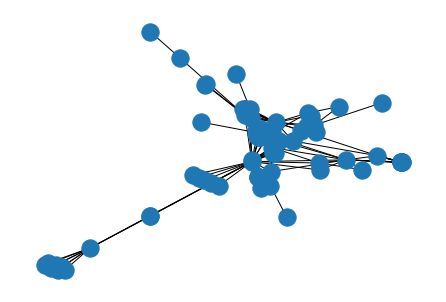

In [36]:
b = study.best_trials[0]
params = {
        'm_averageIterationsPerNode': b.params['m_averageIterationsPerNode'],
        'm_nodeDistanceStrengthConstant': b.params['m_nodeDistanceStrengthConstant'],
        'm_nodeDistanceRestLengthConstant': b.params['m_nodeDistanceRestLengthConstant'],
        'm_disconnectedNodeDistanceSpringStrength': b.params['m_disconnectedNodeDistanceSpringStrength'],
        'm_disconnectedNodeDistanceSpringRestLength': b.params['m_disconnectedNodeDistanceSpringRestLength'],
        'm_anticollisionSpringStrength': b.params['m_anticollisionSpringStrength'],
        'm_layoutPass': b.params['m_layoutPass'],
        'singlePartition': False,
        'unweighted': False,
        'randomize': False
    }
pos = draw_graph(nx_graph, params)
nx.draw(nx_graph, pos)
plt.show()

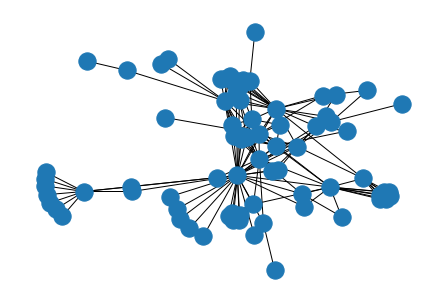

In [35]:
nx.draw(nx_graph, pos)

In [23]:
quality_metrics_names

['angular_resolution',
 'aspect_ratio',
 'crossing_angle_maximization',
 'crossing_number',
 'gabriel_graph_property',
 'ideal_edge_length',
 'node_resolution',
 'shape_based_metrics',
 'stress']

In [33]:
print([quality_metrics_direction[k] for k in quality_metrics_names])
print(quality_metrics_names)

for a, b in zip([quality_metrics_direction[k] for k in quality_metrics_names], quality_metrics_names):
    print(a,b)

['maximize', 'maximize', 'maximize', 'minimize', 'minimize', 'minimize', 'maximize', 'maximize', 'minimize']
['angular_resolution', 'aspect_ratio', 'crossing_angle_maximization', 'crossing_number', 'gabriel_graph_property', 'ideal_edge_length', 'node_resolution', 'shape_based_metrics', 'stress']
maximize angular_resolution
maximize aspect_ratio
maximize crossing_angle_maximization
minimize crossing_number
minimize gabriel_graph_property
minimize ideal_edge_length
maximize node_resolution
maximize shape_based_metrics
minimize stress


In [34]:
print(randomized_mean)
print(optimized_mean)
for a,b in zip(randomized_mean, optimized_mean):
    print(a/b)

[128.26950758864888, 0.8462447222425235, 156.51210422358085, 794.79, 146445.91248654298, 374666.1930745407, 20.459449624162538, 0.28348556370950057, 2084740057948.6855]
[129.8325745328674, 0.7993395799456945, 145.55448165008102, 766.5853658536586, 121111.61370729165, 254528.4663745134, 24.948867901783053, 0.29134995330061414, 1533375330638.7556]
0.9879609031104685
1.0586798695743498
1.0752819318874867
1.0367925548838688
1.2091814154213194
1.472001141606128
0.820055230750584
0.9730070676105477
1.3595758431044074


Applying default style...
Applying preferred layout


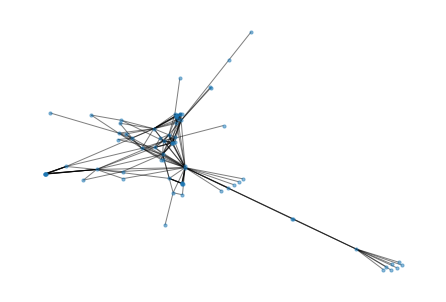

Applying default style...
Applying preferred layout


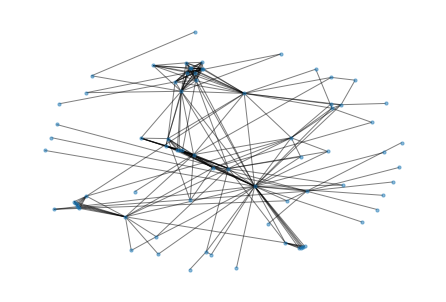

Applying default style...
Applying preferred layout


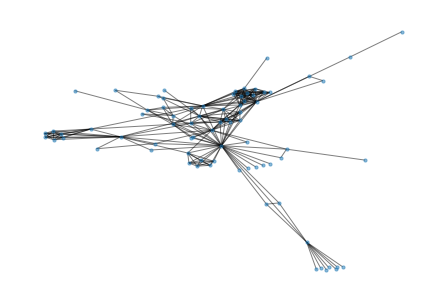

Applying default style...
Applying preferred layout


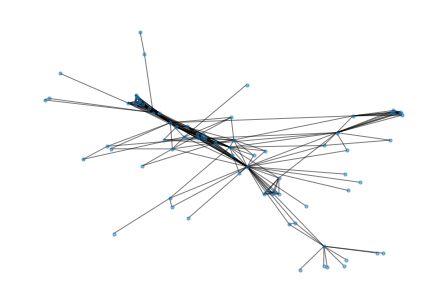

Applying default style...
Applying preferred layout


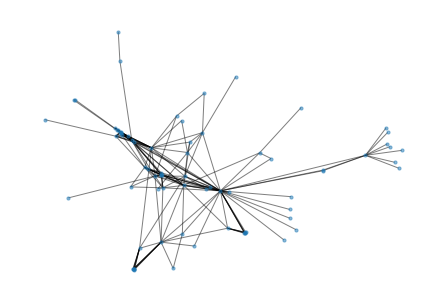

Applying default style...
Applying preferred layout


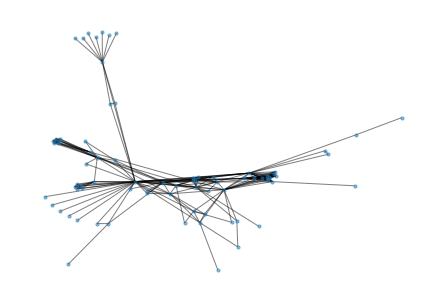

Applying default style...
Applying preferred layout


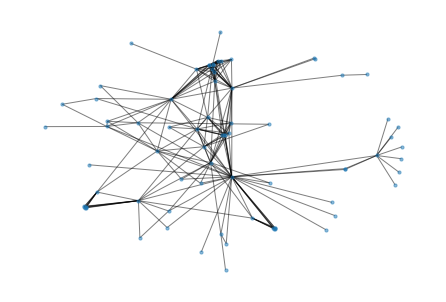

Applying default style...
Applying preferred layout


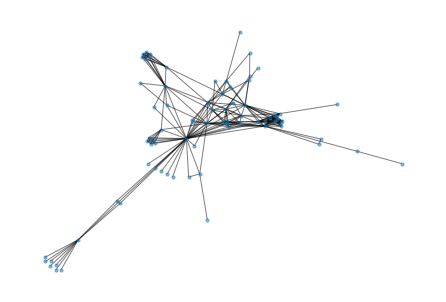

Applying default style...
Applying preferred layout


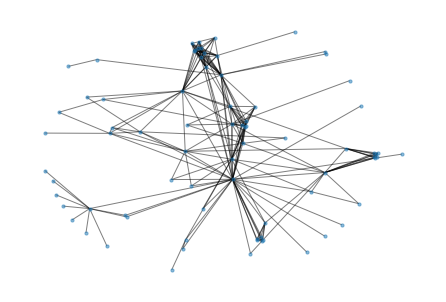

Applying default style...
Applying preferred layout


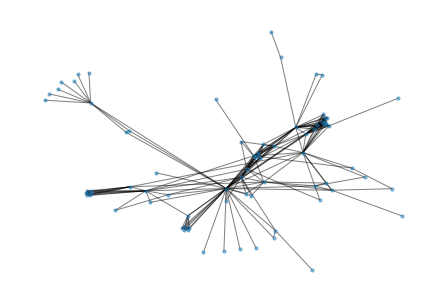

Applying default style...
Applying preferred layout


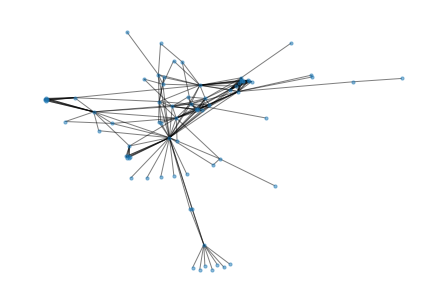

Applying default style...
Applying preferred layout


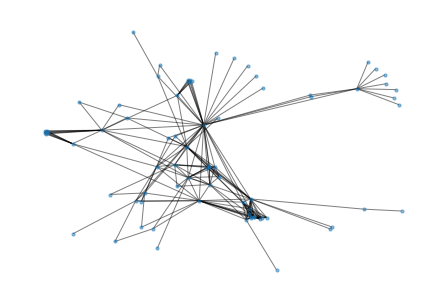

Applying default style...
Applying preferred layout


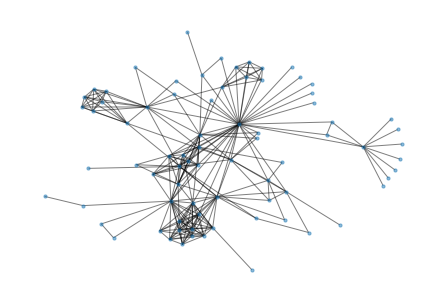

Applying default style...
Applying preferred layout


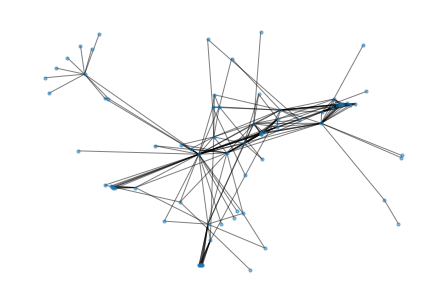

Applying default style...
Applying preferred layout


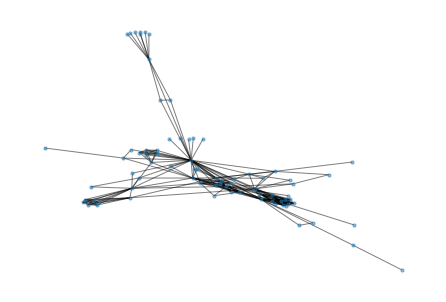

Applying default style...
Applying preferred layout


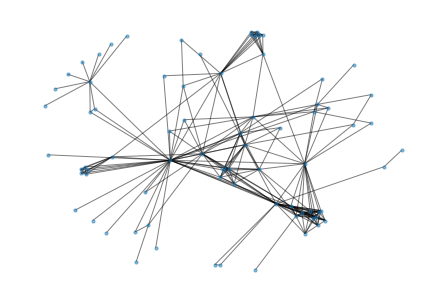

Applying default style...
Applying preferred layout


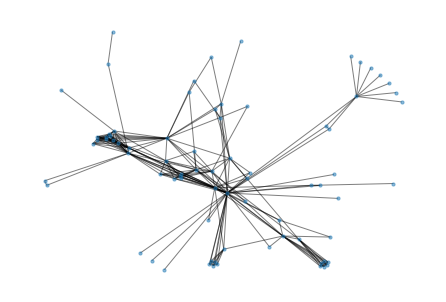

Applying default style...
Applying preferred layout


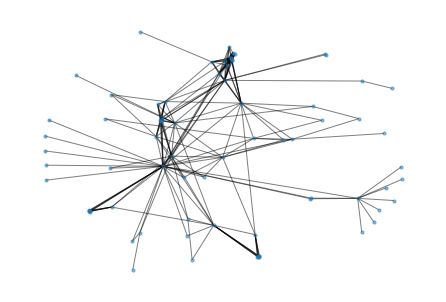

Applying default style...
Applying preferred layout


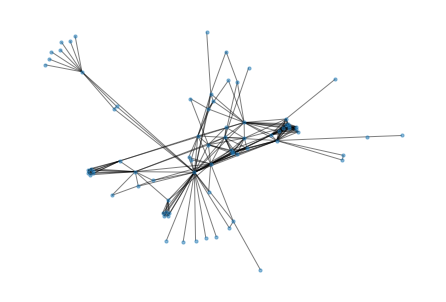

Applying default style...
Applying preferred layout


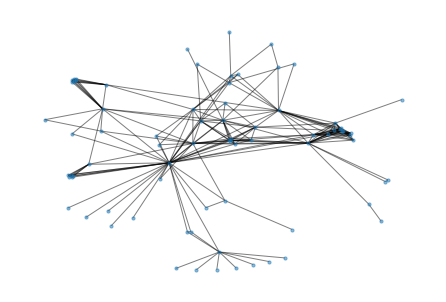

Applying default style...
Applying preferred layout


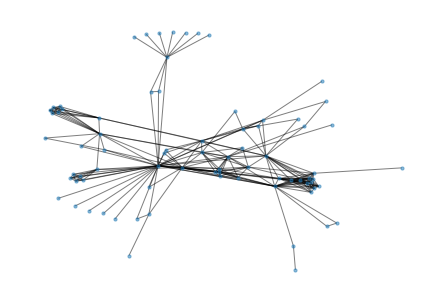

Applying default style...
Applying preferred layout


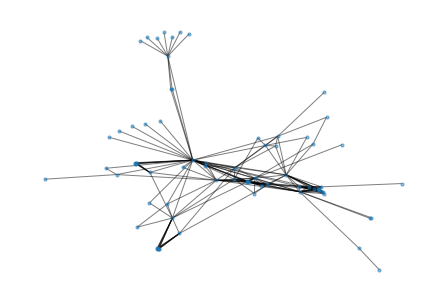

Applying default style...
Applying preferred layout


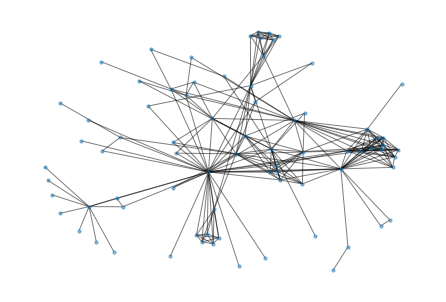

Applying default style...
Applying preferred layout


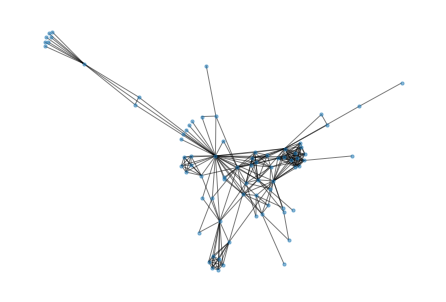

Applying default style...
Applying preferred layout


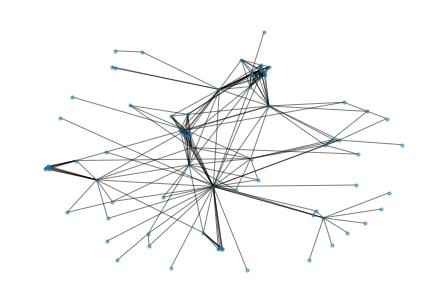

Applying default style...
Applying preferred layout


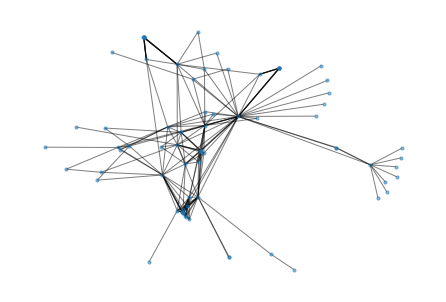

Applying default style...
Applying preferred layout


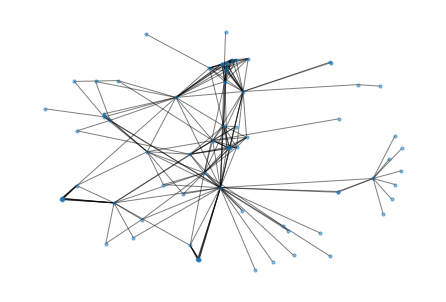

Applying default style...
Applying preferred layout


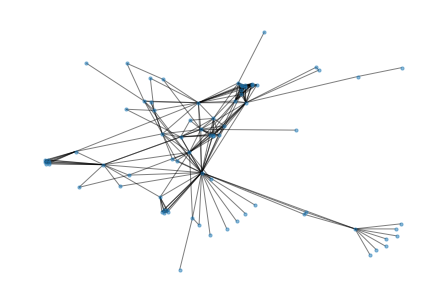

Applying default style...
Applying preferred layout


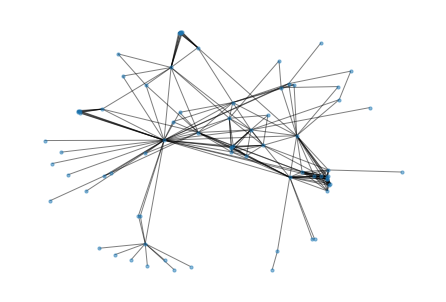

Applying default style...
Applying preferred layout


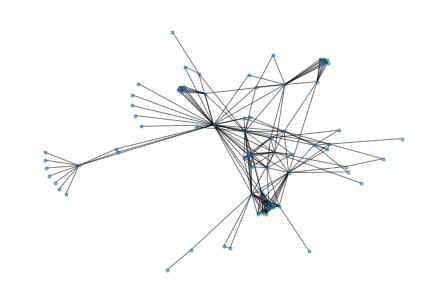

Applying default style...
Applying preferred layout


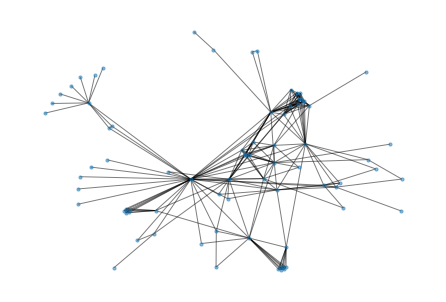

Applying default style...
Applying preferred layout


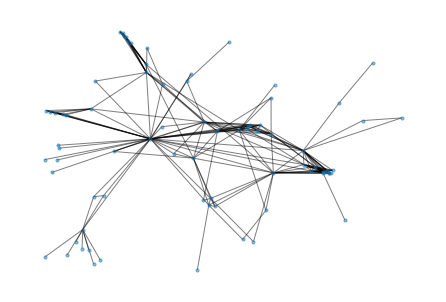

Applying default style...
Applying preferred layout


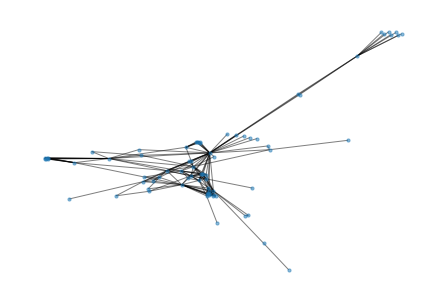

Applying default style...
Applying preferred layout


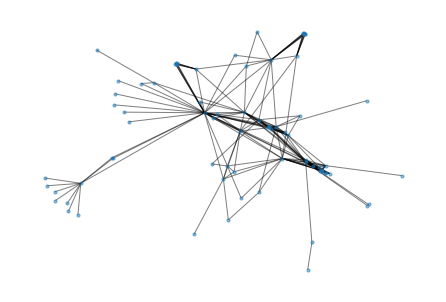

Applying default style...
Applying preferred layout


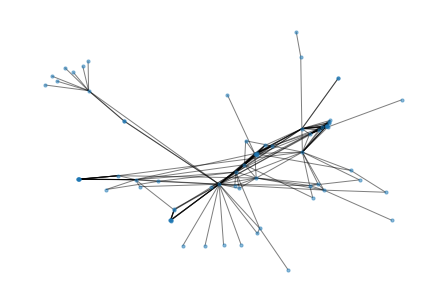

Applying default style...
Applying preferred layout


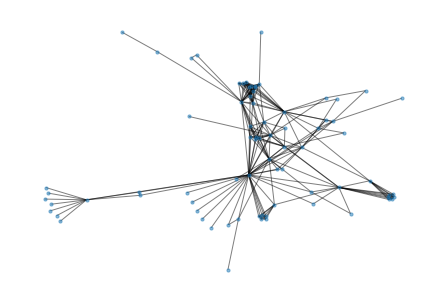

Applying default style...
Applying preferred layout


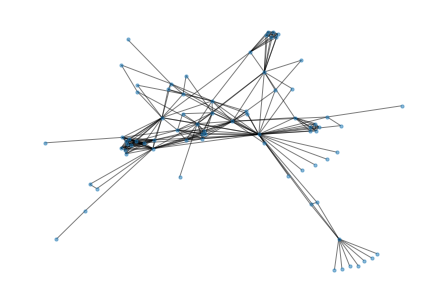

Applying default style...
Applying preferred layout


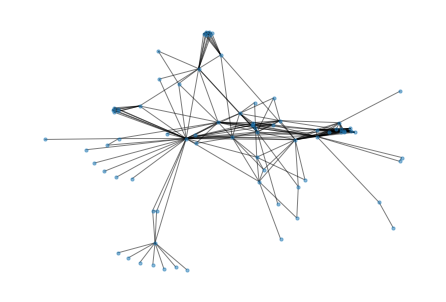

Applying default style...
Applying preferred layout


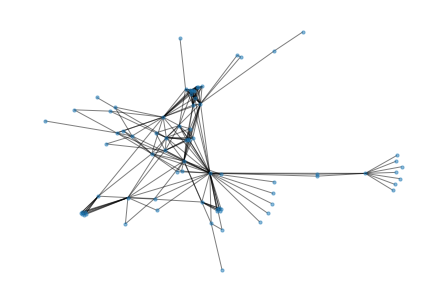

Applying default style...
Applying preferred layout


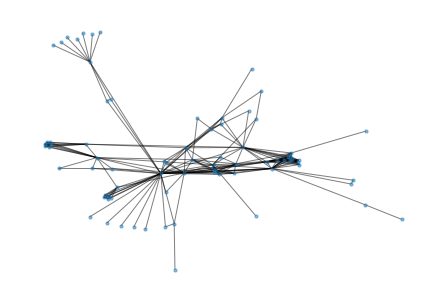

Applying default style...
Applying preferred layout


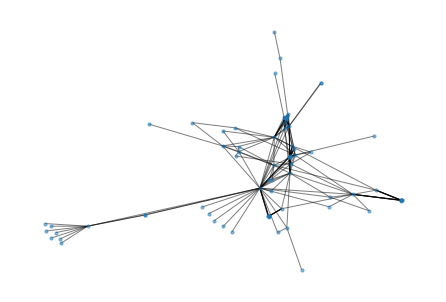

Applying default style...
Applying preferred layout


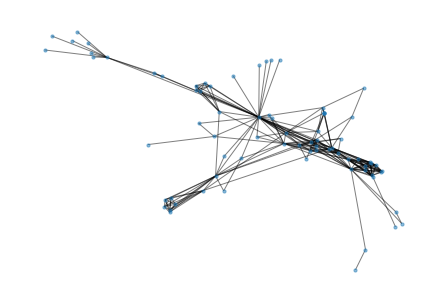

Applying default style...
Applying preferred layout


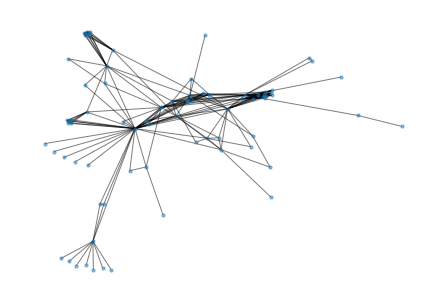

Applying default style...
Applying preferred layout


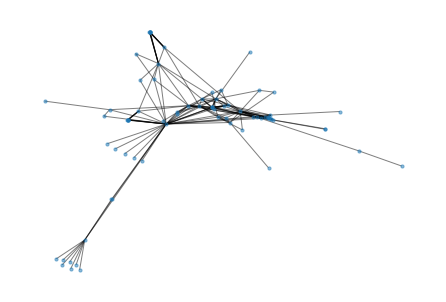

Applying default style...
Applying preferred layout


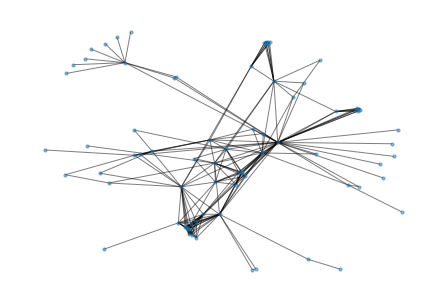

Applying default style...
Applying preferred layout


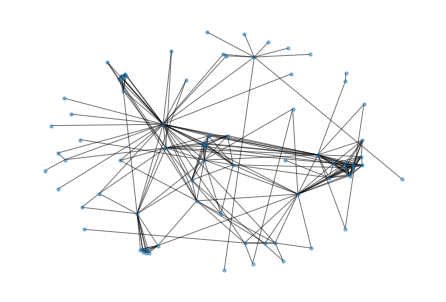

Applying default style...
Applying preferred layout


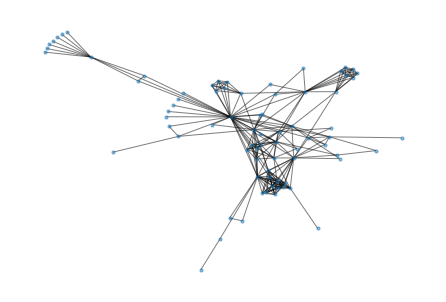

Applying default style...
Applying preferred layout


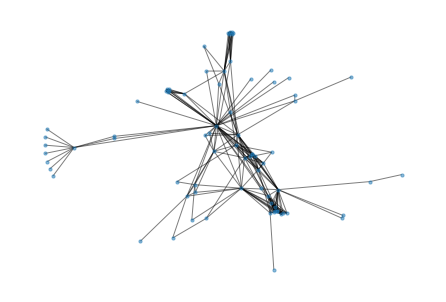

Applying default style...
Applying preferred layout


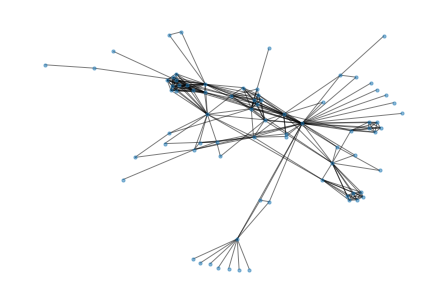

Applying default style...
Applying preferred layout


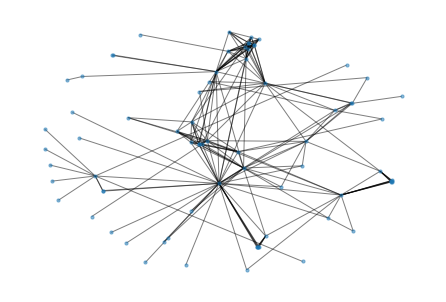

Applying default style...
Applying preferred layout


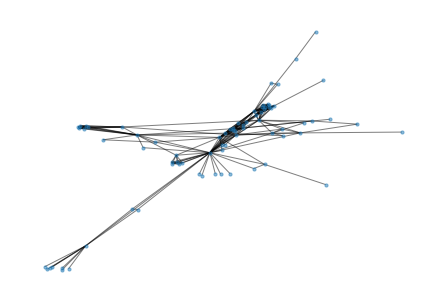

Applying default style...
Applying preferred layout


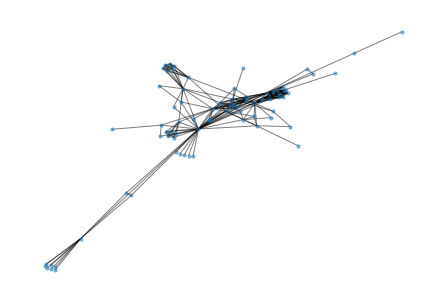

Applying default style...
Applying preferred layout


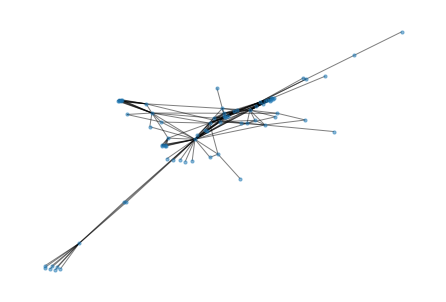

Applying default style...
Applying preferred layout


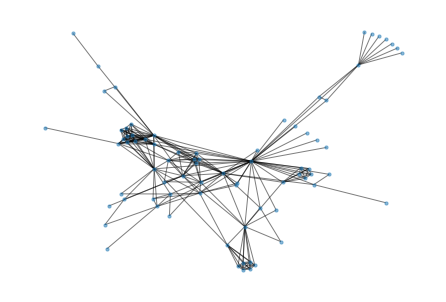

Applying default style...
Applying preferred layout


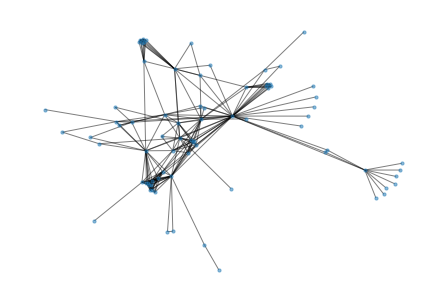

Applying default style...
Applying preferred layout


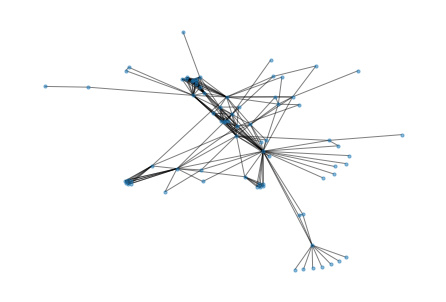

Applying default style...
Applying preferred layout


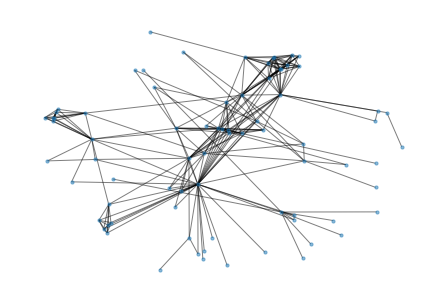

Applying default style...
Applying preferred layout


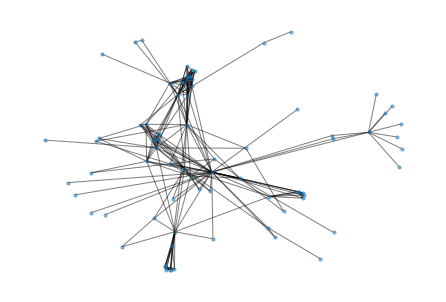

Applying default style...
Applying preferred layout


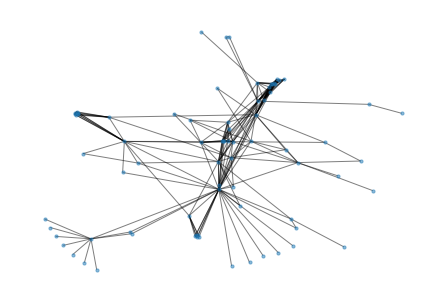

Applying default style...
Applying preferred layout


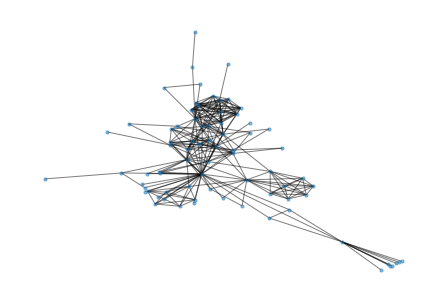

Applying default style...
Applying preferred layout


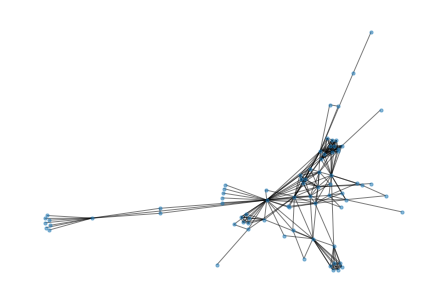

Applying default style...
Applying preferred layout


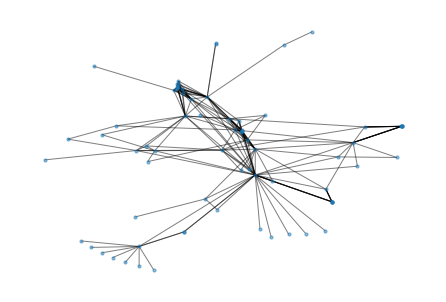

Applying default style...
Applying preferred layout


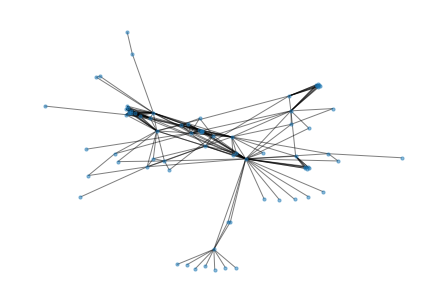

Applying default style...
Applying preferred layout


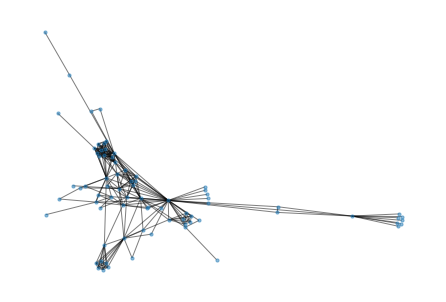

Applying default style...
Applying preferred layout


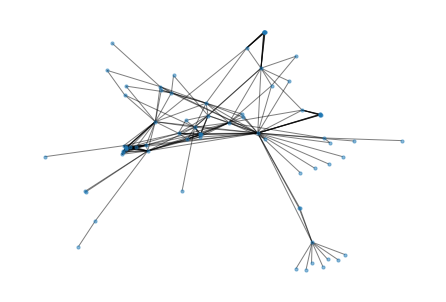

Applying default style...
Applying preferred layout


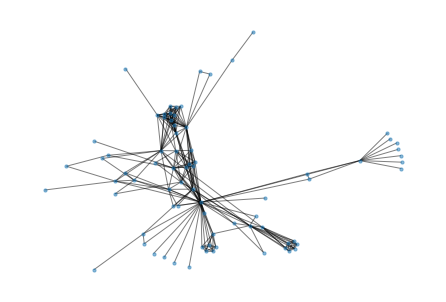

Applying default style...
Applying preferred layout


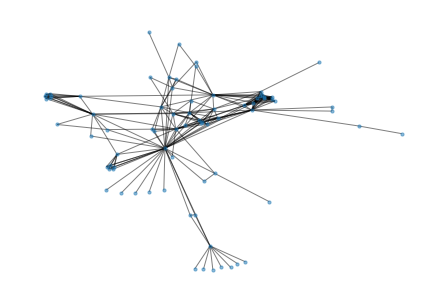

Applying default style...
Applying preferred layout


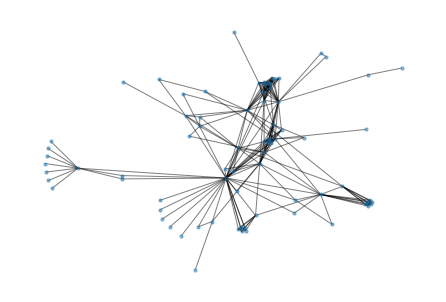

Applying default style...
Applying preferred layout


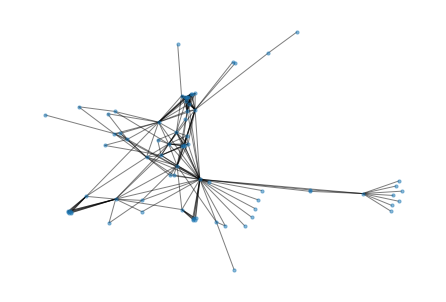

Applying default style...
Applying preferred layout


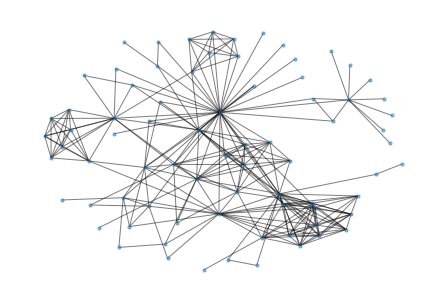

Applying default style...
Applying preferred layout


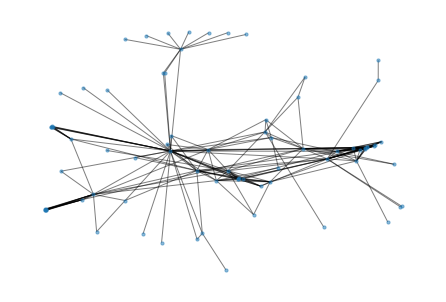

Applying default style...
Applying preferred layout


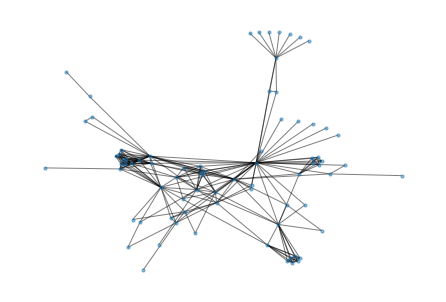

Applying default style...
Applying preferred layout


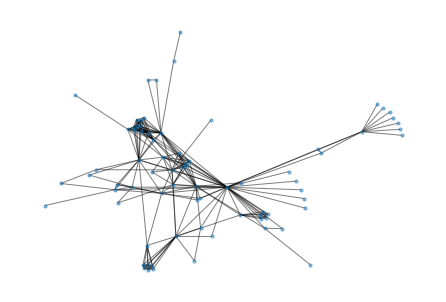

Applying default style...
Applying preferred layout


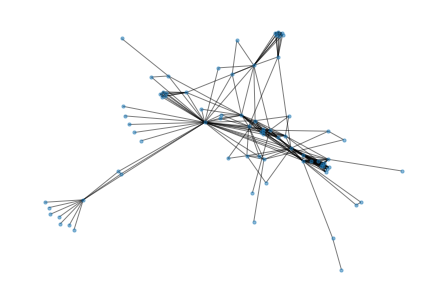

Applying default style...
Applying preferred layout


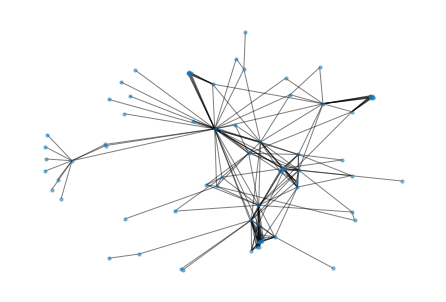

Applying default style...
Applying preferred layout


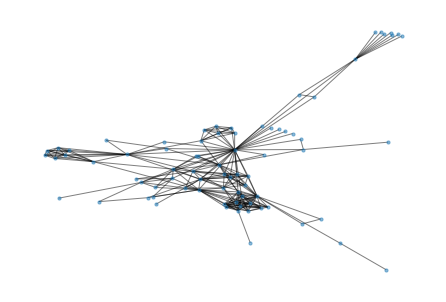

Applying default style...
Applying preferred layout


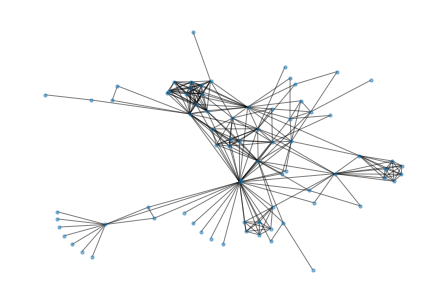

Applying default style...
Applying preferred layout


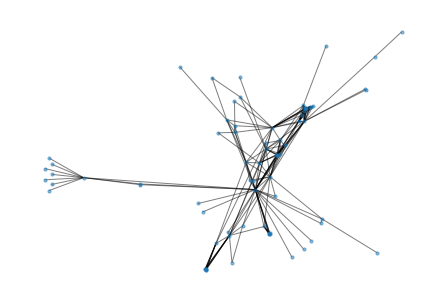

Applying default style...
Applying preferred layout


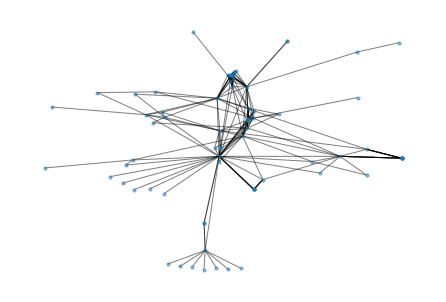

Applying default style...
Applying preferred layout


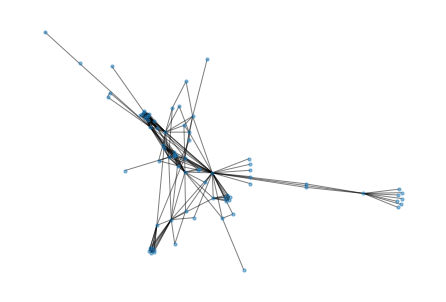

Applying default style...
Applying preferred layout


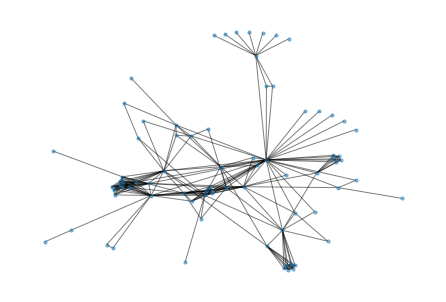

Applying default style...
Applying preferred layout


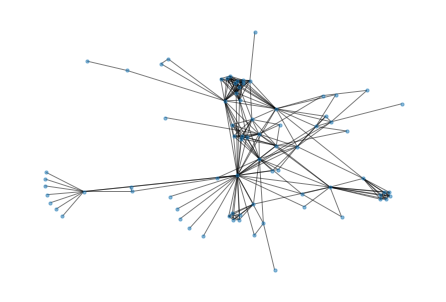

In [25]:
p = {
    'm_averageIterationsPerNode': 0,
    'm_nodeDistanceStrengthConstant': 0,
    'm_nodeDistanceRestLengthConstant': 0,
    'm_disconnectedNodeDistanceSpringStrength': 0,
    'm_disconnectedNodeDistanceSpringRestLength': 0,
    'm_anticollisionSpringStrength': 0,
    'm_layoutPass': 0,
    'singlePartition': False,
    'unweighted': False,
    'randomize': False
}

for b in study.best_trials:
    params = {
        'm_averageIterationsPerNode': b.params['m_averageIterationsPerNode'],
        'm_nodeDistanceStrengthConstant': b.params['m_nodeDistanceStrengthConstant'],
        'm_nodeDistanceRestLengthConstant': b.params['m_nodeDistanceRestLengthConstant'],
        'm_disconnectedNodeDistanceSpringStrength': b.params['m_disconnectedNodeDistanceSpringStrength'],
        'm_disconnectedNodeDistanceSpringRestLength': b.params['m_disconnectedNodeDistanceSpringRestLength'],
        'm_anticollisionSpringStrength': b.params['m_anticollisionSpringStrength'],
        'm_layoutPass': b.params['m_layoutPass'],
        'singlePartition': False,
        'unweighted': False,
        'randomize': False
    }

    p['m_averageIterationsPerNode'] += params['m_averageIterationsPerNode']
    p['m_nodeDistanceStrengthConstant'] += params['m_nodeDistanceStrengthConstant']
    p['m_nodeDistanceRestLengthConstant'] += params['m_nodeDistanceRestLengthConstant']
    p['m_disconnectedNodeDistanceSpringStrength'] += params['m_disconnectedNodeDistanceSpringStrength']
    p['m_disconnectedNodeDistanceSpringRestLength'] += params['m_disconnectedNodeDistanceSpringRestLength']
    p['m_anticollisionSpringStrength'] += params['m_anticollisionSpringStrength']
    p['m_layoutPass'] += params['m_layoutPass']


    p4c.delete_all_networks()
    p4c.create_network_from_networkx(nx_graph)
    p4c.set_layout_properties(
        layout_name=LAYOUT_NAME, properties_dict=params)
    p4c.layout_network(layout_name=LAYOUT_NAME)
    pos = {}
    for i, r in p4c.get_node_position().iterrows():
        pos[i] = (r['x'], r['y'])

    nx.draw(nx_graph, pos, node_size=10, alpha=0.5)
    plt.show()


p['m_averageIterationsPerNode'] /= len(study.best_trials)
p['m_nodeDistanceStrengthConstant'] /= len(study.best_trials)
p['m_nodeDistanceRestLengthConstant'] /= len(study.best_trials)
p['m_disconnectedNodeDistanceSpringStrength'] /= len(study.best_trials)
p['m_disconnectedNodeDistanceSpringRestLength'] /= len(study.best_trials)
p['m_anticollisionSpringStrength'] /= len(study.best_trials)
p['m_layoutPass'] //= len(study.best_trials)

In [26]:
quality_metrics_names

['angular_resolution',
 'aspect_ratio',
 'crossing_angle_maximization',
 'crossing_number',
 'gabriel_graph_property',
 'ideal_edge_length',
 'node_resolution',
 'shape_based_metrics',
 'stress']

In [27]:
trial_results = [t.values for t in study.best_trials]

min_and_max = {}

for name in quality_metrics_names:
    min_and_max[name] = {'max': -float('inf'), 'min': float('inf')}

for trial_result in trial_results:
    for v, name in zip(trial_result, quality_metrics_names):
        if min_and_max[name]['max'] < v:
            min_and_max[name]['max'] = v
        if v < min_and_max[name]['min']:
            min_and_max[name]['min'] = v

normalized_trial_results = []
for trial_result in trial_results:
    normalized_trial_result = []
    for v, name in zip(trial_result, quality_metrics_names):
        min_v = min_and_max[name]['min']
        max_v = min_and_max[name]['max']
        if max_v == min_v:
            normalized_trial_result.append(0)
            continue
        normalized_trial_result.append((v - min_v) / (max_v - min_v))
    normalized_trial_results.append(normalized_trial_result)


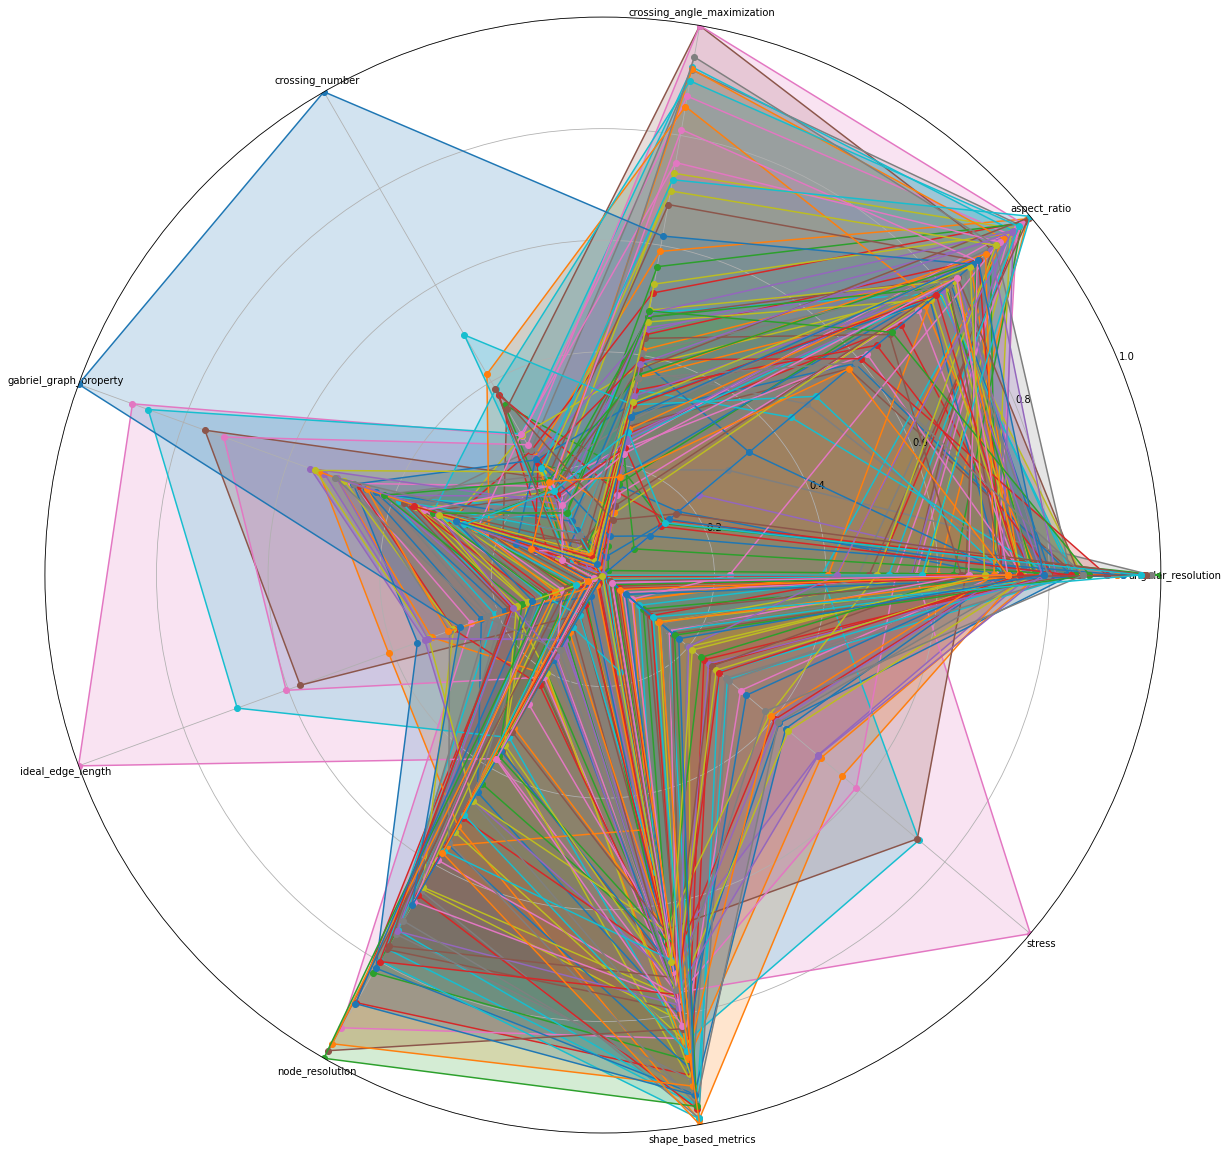

In [28]:
dim = len(quality_metrics_names)
angles = np.linspace(start=0, stop=2 * np.pi, num=dim + 1, endpoint=True)

fig, ax = plt.subplots(1, 1, figsize=(
    20, 24), subplot_kw={'projection': 'polar'})
ax.set_thetagrids(angles[:-1] * 180 / np.pi, quality_metrics_names)
ax.set_rlim(0, 1)
3
for normalized_trial_result in normalized_trial_results:
    concatnate_values = np.concatenate([normalized_trial_result, [
            normalized_trial_result[0]]])
    ax.plot(angles, concatnate_values, 'o-')
    ax.fill(angles, concatnate_values, alpha=0.2)


In [29]:
# import random

# params = {
#     'edge_length': random.randrange(1,100+1),
#     'number_of_pivots': random.randrange(1, len(nx_graph.nodes) + 1),
#     'number_of_iterations': random.randrange(1, 1000+1),
#     'eps': random.uniform(0.01, 1)
# }

# pos = draw_graph(graph, indices, params)
# nx.draw(nx_graph, pos, node_size=10, alpha=0.5)
# plt.show()